In [1]:
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from numpy import argmax
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from tqdm import tqdm
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import GridSearchCV
import collections
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance
import pandas as pd

In [2]:
import numpy as np

In [3]:
human_lombardo = pd.read_csv("../data/human_smiles_r_v3.csv")
human_lombardo = human_lombardo[human_lombardo["smiles_r"]!="Cannot_do"].reset_index(drop=True)

In [4]:
human_lombardo=  human_lombardo[["smiles_r","human_VDss_L_kg","human_CL_mL_min_kg", "human_fup", "human_mrt", "human_thalf"]]

for endpoint in ["human_VDss_L_kg","human_CL_mL_min_kg",  "human_mrt", "human_thalf" ]:
    print("Transformed endpoint to log base 10")
    human_lombardo[endpoint] = np.log10(human_lombardo[endpoint])
human_lombardo

Transformed endpoint to log base 10
Transformed endpoint to log base 10
Transformed endpoint to log base 10
Transformed endpoint to log base 10


smiles_r  human_VDss_L_kg  \
0     C#CCC(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(...         0.006466   
1         C#CCCCC(=O)c1cc(C(C)(C)C)c([O-])c(C(C)(C)C)c1         1.079181   
2     C#CCN(Cc1cc2c(=O)nc(C)[n-]c2cc1C)c1ccc(C(=O)NC...        -0.275724   
3                             C#CC[NH+](C)C(C)Cc1ccccc1         0.278754   
4     C#C[C@@]1(O)[C@@H](CO)O[C@H](n2ccc(N)nc2=O)[C@...         0.041393   
...                                                 ...              ...   
1278                    c1cc2c(c(N3CC[NH2+]CC3)c1)OCCO2         0.556303   
1279                   c1ccc(C2([NH+]3CCCCC3)CCCCC2)cc1         0.838849   
1280              c1ccc(C2(c3ccccc3)CC2C2=[NH+]CCN2)cc1         0.612784   
1281                c1ccc(CN(CC2=[NH+]CCN2)c2ccccc2)cc1         0.591065   
1282                     c1ccc2c(c1)OCC(C1=[NH+]CCN1)O2         0.518514   

      human_CL_mL_min_kg  human_fup  human_mrt  human_thalf  
0               0.638489       0.33   0.568202     1.176091  
1               0.949390        NaN   1.348305     1.705008  
2              -0.537602       0.01   1.482588     1.894870  
3               1.301030       0.13   0.204120     0.113943  
4               0.204120        NaN   1.068186     1.037426  
...                  ...        ...        ...          ...  
1278            0.903090        NaN   1.021189     0.913814  
1279            0.707570       0.35   1.361728     1.204120  
1280            0.934498       0.50   0.892095     0.863323  
1281            1.293804        NaN   0.537819     0.359835  
1282            1.000000        NaN   0.740363     0.623249  

[1283 rows x 6 columns]

In [5]:
human_lombardo.to_csv("Train_data_log_transformed.csv", index=False)

In [6]:
human_smiles_r = human_lombardo[["smiles_r"]]
human_smiles_r

smiles_r
0     C#CCC(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(...
1         C#CCCCC(=O)c1cc(C(C)(C)C)c([O-])c(C(C)(C)C)c1
2     C#CCN(Cc1cc2c(=O)nc(C)[n-]c2cc1C)c1ccc(C(=O)NC...
3                             C#CC[NH+](C)C(C)Cc1ccccc1
4     C#C[C@@]1(O)[C@@H](CO)O[C@H](n2ccc(N)nc2=O)[C@...
...                                                 ...
1278                    c1cc2c(c(N3CC[NH2+]CC3)c1)OCCO2
1279                   c1ccc(C2([NH+]3CCCCC3)CCCCC2)cc1
1280              c1ccc(C2(c3ccccc3)CC2C2=[NH+]CCN2)cc1
1281                c1ccc(CN(CC2=[NH+]CCN2)c2ccccc2)cc1
1282                     c1ccc2c(c1)OCC(C1=[NH+]CCN1)O2

[1283 rows x 1 columns]

In [7]:
from sklearn.feature_selection import VarianceThreshold
from itertools import compress
    
def count(pred, true, min, max, endpoint):

    if(endpoint == "human_fup"):
        lst = [abs(a/b) for a, b in zip(pred, true)]
        #print(lst)

        newlist = [x for x in lst if min <= x <= max]
        #print(newlist)

        return (len(newlist)/len(lst)) *100
    
    else:
        lst = [abs(10**a/10**b) for a, b in zip(pred, true)]
        #print(lst)

        newlist = [x for x in lst if min <= x <= max]
        #print(newlist)

        return (len(newlist)/len(lst)) *100
    
    return

def calc_gmfe(pred, true, endpoint):
    
    if(endpoint == "human_fup"):
        
        lst = [abs(np.log10(a/b)) for a, b in zip(pred, true)]
        mean_abs= np.mean(lst)
        return (10**mean_abs)
    
    else: 
        lst = [abs(np.log10(10**a/10**b)) for a, b in zip(pred, true)]
        mean_abs= np.mean(lst)
        
        return (10** mean_abs)
    
    return
                         
def median_fold_change_error(pred, true, endpoint):
                         
    if (endpoint == "human_fup"):
        lst = [abs(np.log10(a/b)) for a, b in zip(pred, true)]
        median_abs= np.median(lst) 
        return (np.e**median_abs)
    
    else:
        lst = [abs(np.log10(10**a/10**b)) for a, b in zip(pred, true)]
        median_abs= np.median(lst) 
        return (np.e**median_abs)
    
    return
                          
def calc_bias(pred, true, endpoint):
                          
    if (endpoint == "human_fup"):
        lst = [(a - b) for a, b in zip(pred, true)]                 
        bias= np.median(lst)
        return bias
    
    else:
        lst = [(10**a - 10**b) for a, b in zip(pred, true)]                 
        bias= np.median(lst)
        return bias
    
    return

In [8]:
from rdkit import Chem
from mordred import Calculator, descriptors

# create descriptor calculator with all descriptors
calc = Calculator(descriptors, ignore_3D=True)

print(len(calc.descriptors))

Ser_Mol = human_lombardo['smiles_r'].apply(Chem.MolFromSmiles)

# as pandas
Mordred_table=  calc.pandas(Ser_Mol)

1613


  1%|▌                                        | 19/1283 [00:03<05:46,  3.65it/s]

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 19%|███████▋                                | 248/1283 [00:05<00:17, 58.55it/s]

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, ax

 23%|█████████▏                              | 296/1283 [00:05<00:11, 89.14it/s]

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 28%|███████████▏                            | 359/1283 [00:06<00:11, 81.89it/s]

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 32%|████████████▋                           | 407/1283 [00:07<00:10, 83.47it/s]

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 37%|██████████████▋                         | 472/1283 [00:08<00:10, 77.93it/s]

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 41%|███████████████▉                       | 525/1283 [00:08<00:07, 106.09it/s]

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 46%|█████████████████▉                     | 590/1283 [00:09<00:04, 140.19it/s]

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 48%|███████████████████▎                    | 620/1283 [00:10<00:08, 80.73it/s]

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 56%|█████████████████████▉                 | 723/1283 [00:10<00:03, 154.92it/s]

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 69%|███████████████████████████            | 890/1283 [00:11<00:03, 128.45it/s]

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 81%|███████████████████████████████▌       | 1037/1283 [00:13<00:02, 93.58it/s]

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 98%|█████████████████████████████████████▏| 1257/1283 [00:15<00:00, 112.94it/s]

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|███████████████████████████████████████| 1283/1283 [00:16<00:00, 78.73it/s]


In [9]:
Mordred_table = Mordred_table.astype('float')
Mordred_table['smiles_r'] = human_lombardo['smiles_r']
Mordred_table

ABC      ABCGG  nAcid  nBase    SpAbs_A   SpMax_A  SpDiam_A  \
0     26.726479  20.199330    2.0    0.0  43.712035  2.420516  4.841033   
1     16.484101  15.092007    1.0    0.0  24.810570  2.476291  4.952581   
2     30.181133  23.132813    4.0    0.0  49.053928  2.449016  4.898018   
3     10.077834   9.321842    0.0    1.0  17.214150  2.226811  4.453621   
4     14.384684  13.322169    0.0    0.0  23.623048  2.530742  4.897943   
...         ...        ...    ...    ...        ...       ...       ...   
1278  12.606602  10.129166    0.0    1.0  22.084432  2.412947  4.825894   
1279  14.018917  11.675935    0.0    1.0  24.741115  2.478172  4.956344   
1280  16.038187  14.420804    0.0    2.0  27.701443  2.658726  5.024986   
1281  15.515909  12.987974    0.0    2.0  26.938755  2.326623  4.635214   
1282  11.939935   9.906091    0.0    2.0  20.559285  2.387450  4.754235   

         SpAD_A   SpMAD_A   LogEE_A  ...     TSRW10          MW       AMW  \
0     43.712035  1.248915  4.459804  ...  71.132315  475.161514  8.485027   
1     24.810570  1.127753  3.981521  ...  56.111877  299.201654  6.106156   
2     49.053928  1.257793  4.581296  ...  89.010877  529.176450  8.675024   
3     17.214150  1.229582  3.514311  ...  44.372474  188.143376  5.879480   
4     23.623048  1.243318  3.870813  ...  67.418049  267.085521  8.346423   
...         ...       ...       ...  ...        ...         ...       ...   
1278  22.084432  1.380277  3.723828  ...  48.647579  221.128454  6.700862   
1279  24.741115  1.374506  3.833767  ...  51.418286  244.205976  5.550136   
1280  27.701443  1.385072  3.997563  ...  75.593926  263.154275  6.747546   
1281  26.938755  1.346938  3.923960  ...  66.060685  266.165174  6.654129   
1282  20.559285  1.370619  3.669040  ...  60.402256  205.097154  7.324898   

       WPath  WPol  Zagreb1  Zagreb2   mZagreb1  mZagreb2  \
0     4344.0  54.0    176.0    202.0  13.083333  7.805556   
1     1036.0  34.0    110.0    125.0  11.180556  4.750000   
2     5657.0  62.0    202.0    236.0  13.805556  8.611111   
3      337.0  16.0     62.0     67.0   5.333333  3.361111   
4      654.0  34.0    100.0    122.0   8.229167  4.291667   
...      ...   ...      ...      ...        ...       ...   
1278   412.0  24.0     84.0     99.0   3.444444  3.583333   
1279   549.0  29.0     94.0    112.0   4.034722  4.083333   
1280   751.0  30.0    112.0    139.0   4.256944  4.402778   
1281   829.0  24.0    100.0    113.0   4.444444  4.527778   
1282   359.0  20.0     80.0     94.0   3.194444  3.305556   

                                               smiles_r  
0     C#CCC(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(...  
1         C#CCCCC(=O)c1cc(C(C)(C)C)c([O-])c(C(C)(C)C)c1  
2     C#CCN(Cc1cc2c(=O)nc(C)[n-]c2cc1C)c1ccc(C(=O)NC...  
3                             C#CC[NH+](C)C(C)Cc1ccccc1  
4     C#C[C@@]1(O)[C@@H](CO)O[C@H](n2ccc(N)nc2=O)[C@...  
...                                                 ...  
1278                    c1cc2c(c(N3CC[NH2+]CC3)c1)OCCO2  
1279                   c1ccc(C2([NH+]3CCCCC3)CCCCC2)cc1  
1280              c1ccc(C2(c3ccccc3)CC2C2=[NH+]CCN2)cc1  
1281                c1ccc(CN(CC2=[NH+]CCN2)c2ccccc2)cc1  
1282                     c1ccc2c(c1)OCC(C1=[NH+]CCN1)O2  

[1283 rows x 1614 columns]

In [10]:
len(Mordred_table.columns[Mordred_table.isna().any()].tolist())

441

In [11]:
Ser_Mol = human_lombardo['smiles_r'].apply(Chem.MolFromSmiles)

import numpy as np
from rdkit.Chem.rdMolDescriptors import GetMorganFingerprintAsBitVect

Morgan_fingerprint= Ser_Mol.apply(GetMorganFingerprintAsBitVect, args=(2, 2048))
Morganfingerprint_array  = np.stack(Morgan_fingerprint)

Morgan_collection  = []
for x in np.arange(Morganfingerprint_array.shape[1]): #np.arange plus rapide que range
    x = "Mfp"+str(x)
    Morgan_collection.append(x)

Morganfingerprint_table  = pd.DataFrame(Morganfingerprint_array , columns=Morgan_collection )
Morganfingerprint_table['smiles_r'] = human_lombardo['smiles_r']
Morganfingerprint_table

Mfp0  Mfp1  Mfp2  Mfp3  Mfp4  Mfp5  Mfp6  Mfp7  Mfp8  Mfp9  ...  \
0        0     1     0     0     0     0     0     0     0     0  ...   
1        0     0     0     0     0     0     0     0     0     0  ...   
2        0     1     0     0     0     0     0     0     0     0  ...   
3        0     1     0     0     1     0     0     0     0     0  ...   
4        0     0     0     0     0     0     0     0     0     0  ...   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
1278     0     0     0     0     0     0     0     0     0     0  ...   
1279     0     0     1     0     0     0     0     0     0     0  ...   
1280     0     0     0     0     0     0     0     0     0     0  ...   
1281     0     0     0     0     0     0     0     0     0     0  ...   
1282     0     0     0     0     0     0     0     0     0     0  ...   

      Mfp2039  Mfp2040  Mfp2041  Mfp2042  Mfp2043  Mfp2044  Mfp2045  Mfp2046  \
0           0        0        0        0        0        0        0        0   
1           0        0        0        0        0        0        0        0   
2           0        0        0        0        0        0        0        0   
3           0        0        0        0        0        0        0        0   
4           0        0        0        1        0        0        0        0   
...       ...      ...      ...      ...      ...      ...      ...      ...   
1278        0        0        0        0        0        0        0        0   
1279        0        0        0        0        0        0        0        0   
1280        0        0        0        0        0        0        0        0   
1281        0        0        0        0        0        0        0        0   
1282        0        0        0        0        0        0        0        0   

      Mfp2047                                           smiles_r  
0           0  C#CCC(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(...  
1           0      C#CCCCC(=O)c1cc(C(C)(C)C)c([O-])c(C(C)(C)C)c1  
2           0  C#CCN(Cc1cc2c(=O)nc(C)[n-]c2cc1C)c1ccc(C(=O)NC...  
3           0                          C#CC[NH+](C)C(C)Cc1ccccc1  
4           0  C#C[C@@]1(O)[C@@H](CO)O[C@H](n2ccc(N)nc2=O)[C@...  
...       ...                                                ...  
1278        0                    c1cc2c(c(N3CC[NH2+]CC3)c1)OCCO2  
1279        0                   c1ccc(C2([NH+]3CCCCC3)CCCCC2)cc1  
1280        0              c1ccc(C2(c3ccccc3)CC2C2=[NH+]CCN2)cc1  
1281        0                c1ccc(CN(CC2=[NH+]CCN2)c2ccccc2)cc1  
1282        0                     c1ccc2c(c1)OCC(C1=[NH+]CCN1)O2  

[1283 rows x 2049 columns]

In [12]:
human_lombardo_mfp = pd.merge(human_lombardo, Morganfingerprint_table)
human_lombardo_mfp_Mordred = pd.merge(human_lombardo_mfp, Mordred_table)
human_lombardo_mfp_Mordred

#human_lombardo_mfp = pd.merge(human_lombardo, Morganfingerprint_table)
#human_lombardo_mfp_Mordred = pd.merge(human_lombardo_mfp, Mordred_table)
#human_lombardo_mfp_Mordred

smiles_r  human_VDss_L_kg  \
0     C#CCC(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(...         0.006466   
1         C#CCCCC(=O)c1cc(C(C)(C)C)c([O-])c(C(C)(C)C)c1         1.079181   
2     C#CCN(Cc1cc2c(=O)nc(C)[n-]c2cc1C)c1ccc(C(=O)NC...        -0.275724   
3                             C#CC[NH+](C)C(C)Cc1ccccc1         0.278754   
4     C#C[C@@]1(O)[C@@H](CO)O[C@H](n2ccc(N)nc2=O)[C@...         0.041393   
...                                                 ...              ...   
1278                    c1cc2c(c(N3CC[NH2+]CC3)c1)OCCO2         0.556303   
1279                   c1ccc(C2([NH+]3CCCCC3)CCCCC2)cc1         0.838849   
1280              c1ccc(C2(c3ccccc3)CC2C2=[NH+]CCN2)cc1         0.612784   
1281                c1ccc(CN(CC2=[NH+]CCN2)c2ccccc2)cc1         0.591065   
1282                     c1ccc2c(c1)OCC(C1=[NH+]CCN1)O2         0.518514   

      human_CL_mL_min_kg  human_fup  human_mrt  human_thalf  Mfp0  Mfp1  Mfp2  \
0               0.638489       0.33   0.568202     1.176091     0     1     0   
1               0.949390        NaN   1.348305     1.705008     0     0     0   
2              -0.537602       0.01   1.482588     1.894870     0     1     0   
3               1.301030       0.13   0.204120     0.113943     0     1     0   
4               0.204120        NaN   1.068186     1.037426     0     0     0   
...                  ...        ...        ...          ...   ...   ...   ...   
1278            0.903090        NaN   1.021189     0.913814     0     0     0   
1279            0.707570       0.35   1.361728     1.204120     0     0     1   
1280            0.934498       0.50   0.892095     0.863323     0     0     0   
1281            1.293804        NaN   0.537819     0.359835     0     0     0   
1282            1.000000        NaN   0.740363     0.623249     0     0     0   

      Mfp3  ...      SRW10     TSRW10          MW       AMW   WPath  WPol  \
0        0  ...  10.345445  71.132315  475.161514  8.485027  4344.0  54.0   
1        0  ...  10.048237  56.111877  299.201654  6.106156  1036.0  34.0   
2        0  ...  10.533295  89.010877  529.176450  8.675024  5657.0  62.0   
3        0  ...   8.987072  44.372474  188.143376  5.879480   337.0  16.0   
4        0  ...  10.060961  67.418049  267.085521  8.346423   654.0  34.0   
...    ...  ...        ...        ...         ...       ...     ...   ...   
1278     0  ...   9.706073  48.647579  221.128454  6.700862   412.0  24.0   
1279     0  ...   9.934065  51.418286  244.205976  5.550136   549.0  29.0   
1280     0  ...  10.245906  75.593926  263.154275  6.747546   751.0  30.0   
1281     0  ...   9.582249  66.060685  266.165174  6.654129   829.0  24.0   
1282     0  ...   9.585003  60.402256  205.097154  7.324898   359.0  20.0   

      Zagreb1  Zagreb2   mZagreb1  mZagreb2  
0       176.0    202.0  13.083333  7.805556  
1       110.0    125.0  11.180556  4.750000  
2       202.0    236.0  13.805556  8.611111  
3        62.0     67.0   5.333333  3.361111  
4       100.0    122.0   8.229167  4.291667  
...       ...      ...        ...       ...  
1278     84.0     99.0   3.444444  3.583333  
1279     94.0    112.0   4.034722  4.083333  
1280    112.0    139.0   4.256944  4.402778  
1281    100.0    113.0   4.444444  4.527778  
1282     80.0     94.0   3.194444  3.305556  

[1283 rows x 3667 columns]

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import pickle
def predict_animal(data, endpoint, animal):#log human_VDss_L_kg model
    
    #Read columns needed for animal data
    file = open(f"features_mfp_mordred_columns_{animal}_model.txt", "r")
    file_lines = file.read()
    features = file_lines.split("\n")
    features = features[:-1]

    loaded_rf = pickle.load(open(f"log_{endpoint}_model_FINAL.sav", 'rb'))

    X = data[features]
    #Replace missing descriptors with median

    imp=SimpleImputer(missing_values=np.nan, strategy='median')
    X_new=pd.DataFrame(imp.fit_transform(X))
    X_new.columns=X.columns
    X_new.index=X.index
    
    # Load the scaler from the file
    with open(f'scaler_{animal}.pkl', 'rb') as file:
        scaler = pickle.load(file)

    # Scale the features using the loaded scaler
    X_new = scaler.transform(X_new)
    X_new = pd.DataFrame(X_new, columns=features)
    

    y_pred =  loaded_rf.predict(X_new)   

    return(y_pred)

In [14]:
human_lombardo_mfp_Mordred_animal = human_lombardo_mfp_Mordred
human_lombardo_mfp_Mordred_animal

smiles_r  human_VDss_L_kg  \
0     C#CCC(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(...         0.006466   
1         C#CCCCC(=O)c1cc(C(C)(C)C)c([O-])c(C(C)(C)C)c1         1.079181   
2     C#CCN(Cc1cc2c(=O)nc(C)[n-]c2cc1C)c1ccc(C(=O)NC...        -0.275724   
3                             C#CC[NH+](C)C(C)Cc1ccccc1         0.278754   
4     C#C[C@@]1(O)[C@@H](CO)O[C@H](n2ccc(N)nc2=O)[C@...         0.041393   
...                                                 ...              ...   
1278                    c1cc2c(c(N3CC[NH2+]CC3)c1)OCCO2         0.556303   
1279                   c1ccc(C2([NH+]3CCCCC3)CCCCC2)cc1         0.838849   
1280              c1ccc(C2(c3ccccc3)CC2C2=[NH+]CCN2)cc1         0.612784   
1281                c1ccc(CN(CC2=[NH+]CCN2)c2ccccc2)cc1         0.591065   
1282                     c1ccc2c(c1)OCC(C1=[NH+]CCN1)O2         0.518514   

      human_CL_mL_min_kg  human_fup  human_mrt  human_thalf  Mfp0  Mfp1  Mfp2  \
0               0.638489       0.33   0.568202     1.176091     0     1     0   
1               0.949390        NaN   1.348305     1.705008     0     0     0   
2              -0.537602       0.01   1.482588     1.894870     0     1     0   
3               1.301030       0.13   0.204120     0.113943     0     1     0   
4               0.204120        NaN   1.068186     1.037426     0     0     0   
...                  ...        ...        ...          ...   ...   ...   ...   
1278            0.903090        NaN   1.021189     0.913814     0     0     0   
1279            0.707570       0.35   1.361728     1.204120     0     0     1   
1280            0.934498       0.50   0.892095     0.863323     0     0     0   
1281            1.293804        NaN   0.537819     0.359835     0     0     0   
1282            1.000000        NaN   0.740363     0.623249     0     0     0   

      Mfp3  ...      SRW10     TSRW10          MW       AMW   WPath  WPol  \
0        0  ...  10.345445  71.132315  475.161514  8.485027  4344.0  54.0   
1        0  ...  10.048237  56.111877  299.201654  6.106156  1036.0  34.0   
2        0  ...  10.533295  89.010877  529.176450  8.675024  5657.0  62.0   
3        0  ...   8.987072  44.372474  188.143376  5.879480   337.0  16.0   
4        0  ...  10.060961  67.418049  267.085521  8.346423   654.0  34.0   
...    ...  ...        ...        ...         ...       ...     ...   ...   
1278     0  ...   9.706073  48.647579  221.128454  6.700862   412.0  24.0   
1279     0  ...   9.934065  51.418286  244.205976  5.550136   549.0  29.0   
1280     0  ...  10.245906  75.593926  263.154275  6.747546   751.0  30.0   
1281     0  ...   9.582249  66.060685  266.165174  6.654129   829.0  24.0   
1282     0  ...   9.585003  60.402256  205.097154  7.324898   359.0  20.0   

      Zagreb1  Zagreb2   mZagreb1  mZagreb2  
0       176.0    202.0  13.083333  7.805556  
1       110.0    125.0  11.180556  4.750000  
2       202.0    236.0  13.805556  8.611111  
3        62.0     67.0   5.333333  3.361111  
4       100.0    122.0   8.229167  4.291667  
...       ...      ...        ...       ...  
1278     84.0     99.0   3.444444  3.583333  
1279     94.0    112.0   4.034722  4.083333  
1280    112.0    139.0   4.256944  4.402778  
1281    100.0    113.0   4.444444  4.527778  
1282     80.0     94.0   3.194444  3.305556  

[1283 rows x 3667 columns]

In [15]:
endpoints = ["dog_VDss_L_kg","dog_CL_mL_min_kg","dog_fup"]

for endpoint in endpoints:
    print(endpoint)
    preds = predict_animal(human_lombardo_mfp_Mordred_animal, endpoint, "dog") 
    human_lombardo_mfp_Mordred_animal[endpoint] = preds

dog_VDss_L_kg
dog_CL_mL_min_kg


/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


dog_fup


/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [16]:
endpoints = ["monkey_VDss_L_kg","monkey_CL_mL_min_kg","monkey_fup"]

for endpoint in endpoints:
    print(endpoint)
    preds = predict_animal(human_lombardo_mfp_Mordred_animal, endpoint, "monkey") 
    human_lombardo_mfp_Mordred_animal[endpoint] = preds

monkey_VDss_L_kg


/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


monkey_CL_mL_min_kg
monkey_fup


/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [17]:
endpoints = ["rat_VDss_L_kg","rat_CL_mL_min_kg","rat_fup"]

for endpoint in endpoints:
    print(endpoint)
    preds = predict_animal(human_lombardo_mfp_Mordred_animal, endpoint, "rat") 
    human_lombardo_mfp_Mordred_animal[endpoint] = preds

rat_VDss_L_kg
rat_CL_mL_min_kg


/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


rat_fup


/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [18]:
human_lombardo_mfp_Mordred_animal

smiles_r  human_VDss_L_kg  \
0     C#CCC(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(...         0.006466   
1         C#CCCCC(=O)c1cc(C(C)(C)C)c([O-])c(C(C)(C)C)c1         1.079181   
2     C#CCN(Cc1cc2c(=O)nc(C)[n-]c2cc1C)c1ccc(C(=O)NC...        -0.275724   
3                             C#CC[NH+](C)C(C)Cc1ccccc1         0.278754   
4     C#C[C@@]1(O)[C@@H](CO)O[C@H](n2ccc(N)nc2=O)[C@...         0.041393   
...                                                 ...              ...   
1278                    c1cc2c(c(N3CC[NH2+]CC3)c1)OCCO2         0.556303   
1279                   c1ccc(C2([NH+]3CCCCC3)CCCCC2)cc1         0.838849   
1280              c1ccc(C2(c3ccccc3)CC2C2=[NH+]CCN2)cc1         0.612784   
1281                c1ccc(CN(CC2=[NH+]CCN2)c2ccccc2)cc1         0.591065   
1282                     c1ccc2c(c1)OCC(C1=[NH+]CCN1)O2         0.518514   

      human_CL_mL_min_kg  human_fup  human_mrt  human_thalf  Mfp0  Mfp1  Mfp2  \
0               0.638489       0.33   0.568202     1.176091     0     1     0   
1               0.949390        NaN   1.348305     1.705008     0     0     0   
2              -0.537602       0.01   1.482588     1.894870     0     1     0   
3               1.301030       0.13   0.204120     0.113943     0     1     0   
4               0.204120        NaN   1.068186     1.037426     0     0     0   
...                  ...        ...        ...          ...   ...   ...   ...   
1278            0.903090        NaN   1.021189     0.913814     0     0     0   
1279            0.707570       0.35   1.361728     1.204120     0     0     1   
1280            0.934498       0.50   0.892095     0.863323     0     0     0   
1281            1.293804        NaN   0.537819     0.359835     0     0     0   
1282            1.000000        NaN   0.740363     0.623249     0     0     0   

      Mfp3  ...  mZagreb2  dog_VDss_L_kg  dog_CL_mL_min_kg   dog_fup  \
0        0  ...  7.805556      -0.232622          0.230128  0.500081   
1        0  ...  4.750000       0.910793          1.496814  0.246874   
2        0  ...  8.611111      -0.080435          0.519013  0.404340   
3        0  ...  3.361111       0.697023          1.921504  0.552944   
4        0  ...  4.291667       0.002723          0.990488  0.799640   
...    ...  ...       ...            ...               ...       ...   
1278     0  ...  3.583333       0.370300          1.385584  0.575267   
1279     0  ...  4.083333       0.858639          1.703382  0.428996   
1280     0  ...  4.402778       0.508658          1.423452  0.207966   
1281     0  ...  4.527778       0.459083          1.429387  0.216230   
1282     0  ...  3.305556       0.200579          1.206020  0.648077   

      monkey_VDss_L_kg  monkey_CL_mL_min_kg  monkey_fup  rat_VDss_L_kg  \
0            -0.454102             0.746751    0.384891      -0.321506   
1             0.726009             1.215557    0.309674       0.773855   
2            -0.423737             0.720220    0.321142      -0.136032   
3             0.457771             1.246978    0.410841       0.623904   
4             0.497278             1.276801    0.603479       0.300622   
...                ...                  ...         ...            ...   
1278          0.260468             1.176282    0.521004       0.502624   
1279          0.657352             1.405757    0.318000       0.900891   
1280          0.297007             1.224678    0.257045       0.672991   
1281          0.285085             1.257072    0.294399       0.608426   
1282          0.117346             1.197067    0.535784       0.448416   

      rat_CL_mL_min_kg   rat_fup  
0             1.201748  0.469607  
1             1.597333  0.279784  
2             1.058891  0.280002  
3             1.767083  0.310000  
4             1.284621  0.797380  
...                ...       ...  
1278          1.666512  0.541654  
1279          1.783126  0.372337  
1280          1.608588  0.304375  
1281          1.639394  0.384213  
1282          1.741828

In [19]:
X = pd.DataFrame(human_lombardo_mfp_Mordred_animal.median()).T.iloc[:,2053:-9]
X.to_csv("Median_mordred_values_human_for_artificial_animal_data_mfp_mrd_model.csv", index=False)
X

/tmp/ipykernel_1124016/3703266355.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  X = pd.DataFrame(human_lombardo_mfp_Mordred_animal.median()).T.iloc[:,2053:-9]


ABC      ABCGG  nAcid  nBase    SpAbs_A   SpMax_A  SpDiam_A  \
0  19.854202  16.164169    0.0    1.0  32.670627  2.475468  4.898018   

      SpAD_A   SpMAD_A   LogEE_A  ...      SRW10     TSRW10          MW  \
0  32.670627  1.265133  4.173171  ...  10.226549  70.336447  363.121906   

        AMW   WPath  WPol  Zagreb1  Zagreb2  mZagreb1  mZagreb2  
0  7.469697  1596.0  41.0    134.0    160.0  8.861111     5.625  

[1 rows x 1613 columns]

In [20]:
animal_columns = ["dog_VDss_L_kg","dog_CL_mL_min_kg","dog_fup","monkey_VDss_L_kg","monkey_CL_mL_min_kg","monkey_fup", "rat_VDss_L_kg","rat_CL_mL_min_kg","rat_fup"]

file = open("features_mfp_mordred_columns_human.txt", "r")
file_lines = file.read()
features_mfp_mordred_columns = file_lines.split("\n")
features_mfp_mordred_columns = features_mfp_mordred_columns[:-1]

In [21]:
features_mfp_mordred_animal_columns = features_mfp_mordred_columns + animal_columns
print(len(features_mfp_mordred_animal_columns))

513


In [22]:
#Write to file
#len(features_mfp_mordred_columns)
f = open("features_mfp_mordred_animal_artificial_human_modelcolumns.txt", "w")
for item in features_mfp_mordred_animal_columns:
   f.write(item + "\n")
f.close()

human_VDss_L_kg
0
(999, 513)
(250, 513)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=42)
Calculating Permutation Importances
250
2-fold :  56.39999999999999
3-fold :  74.4
5-fold :  88.0
gmfe :  2.143690991875646
mfe :  1.295998740214854
bias :  0.020964001582023342
rmse  0.44177275176976116
r2  0.5476745129536377
saving model


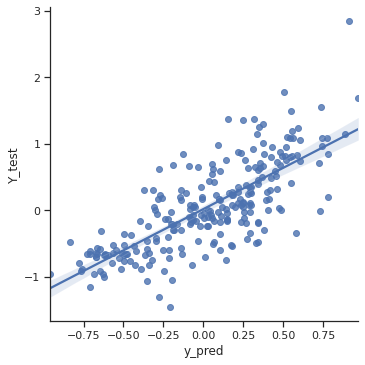

1
(999, 513)
(250, 513)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=42)
Calculating Permutation Importances
250
2-fold :  59.199999999999996
3-fold :  77.60000000000001
5-fold :  89.2
gmfe :  2.064582422152796
mfe :  1.2803295421880914
bias :  0.1032627651859751
rmse  0.4087031604840884
r2  0.5525877601632347
saving model


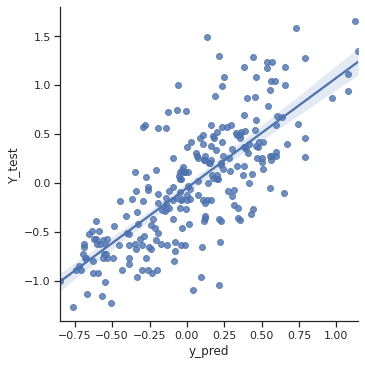

2
(999, 513)
(250, 513)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=42)
Calculating Permutation Importances
250
2-fold :  57.599999999999994
3-fold :  74.8
5-fold :  85.2
gmfe :  2.1969324193066666
mfe :  1.2619188938016765
bias :  -0.0005850042358737928
rmse  0.47350541881398656
r2  0.48384043004156785


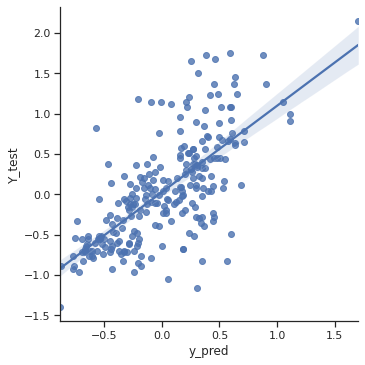

3
(999, 513)
(250, 513)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=42)
Calculating Permutation Importances
250
2-fold :  59.599999999999994
3-fold :  74.8
5-fold :  90.4
gmfe :  2.099182425791203
mfe :  1.292880716869215
bias :  0.013990007928352921
rmse  0.42320057097905156
r2  0.5723538255217425


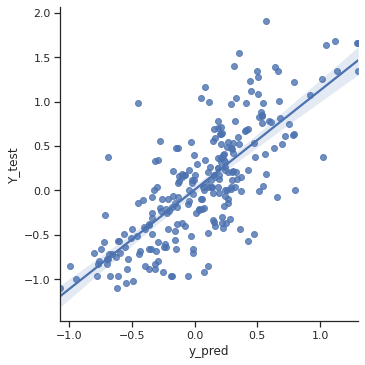

4
(1000, 513)
(249, 513)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_jobs=30, random_state=42)
Calculating Permutation Importances
249
2-fold :  53.41365461847389
3-fold :  75.1004016064257
5-fold :  90.76305220883533
gmfe :  2.175660237381565
mfe :  1.3200549200277543
bias :  0.059467037744931145
rmse  0.43940635353949903
r2  0.4995705881292225


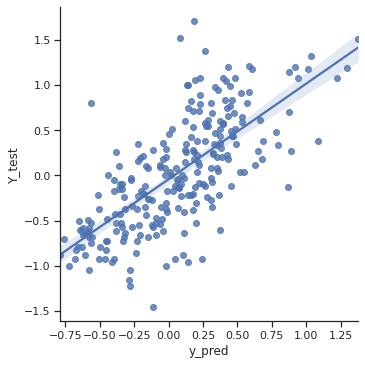

0
(999, 513)
(250, 513)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_jobs=30, random_state=43)
Calculating Permutation Importances
250
2-fold :  57.99999999999999
3-fold :  73.6
5-fold :  89.2
gmfe :  2.137113907541771
mfe :  1.2966948664571467
bias :  0.0356047930178046
rmse  0.4281152658684232
r2  0.4982422679789077


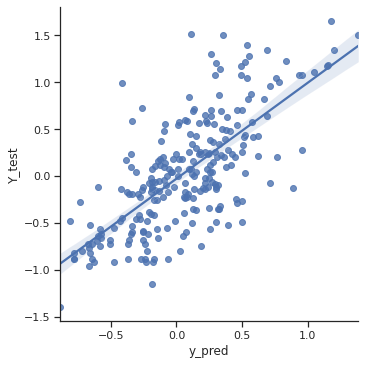

1
(999, 513)
(250, 513)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=43)
Calculating Permutation Importances
250
2-fold :  53.6
3-fold :  72.0
5-fold :  87.6
gmfe :  2.259437481928388
mfe :  1.307044376853969
bias :  0.0172489817066359
rmse  0.4678708498174913
r2  0.5240101975135083


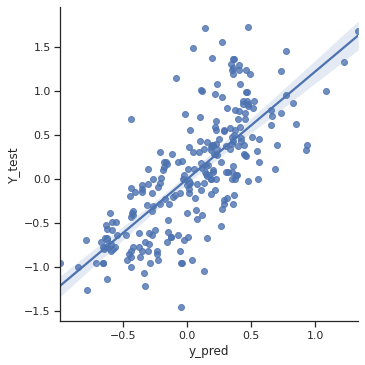

2
(999, 513)
(250, 513)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=43)
Calculating Permutation Importances
250
2-fold :  61.6
3-fold :  79.2
5-fold :  90.4
gmfe :  2.0633385757501155
mfe :  1.2529272541823469
bias :  0.026587635256070496
rmse  0.4332240165695412
r2  0.5221198798727757
saving model


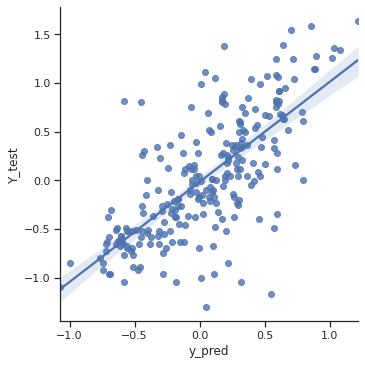

3
(999, 513)
(250, 513)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=43)
Calculating Permutation Importances
250
2-fold :  60.0
3-fold :  76.8
5-fold :  91.60000000000001
gmfe :  2.045364593741171
mfe :  1.2576340933817536
bias :  0.018331717135737252
rmse  0.42775654970391336
r2  0.5489388518269767
saving model


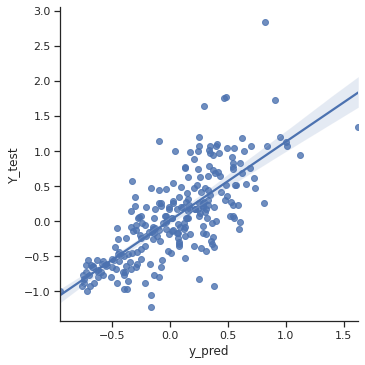

4
(1000, 513)
(249, 513)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=43)
Calculating Permutation Importances
249
2-fold :  55.42168674698795
3-fold :  74.29718875502009
5-fold :  90.76305220883533
gmfe :  2.1227175623148438
mfe :  1.2973218939002973
bias :  0.028513307530611126
rmse  0.4342010006481671
r2  0.5519805461223769


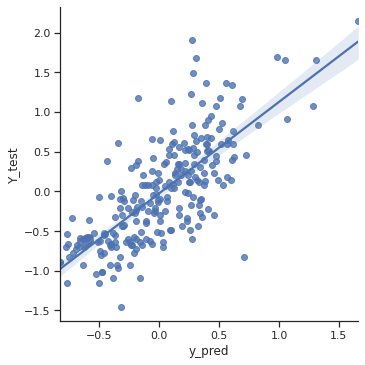

0
(999, 513)
(250, 513)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_jobs=30, random_state=44)
Calculating Permutation Importances
250
2-fold :  55.2
3-fold :  73.6
5-fold :  86.0
gmfe :  2.204623489674565
mfe :  1.3025400554396287
bias :  0.0205125681786493
rmse  0.4662491521773282
r2  0.46885848107602723


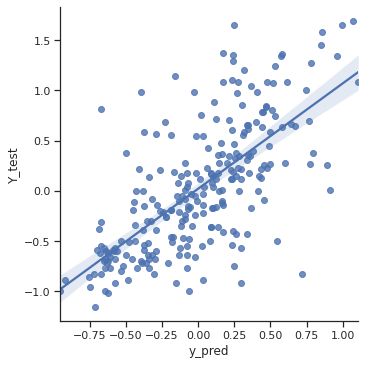

1
(999, 513)
(250, 513)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_estimators=300, n_jobs=30,
                      random_state=44)
Calculating Permutation Importances
250
2-fold :  56.8
3-fold :  75.6
5-fold :  88.8
gmfe :  2.2112015206037112
mfe :  1.310647401942747
bias :  0.03794479333085418
rmse  0.4525087360701174
r2  0.5481333423317534


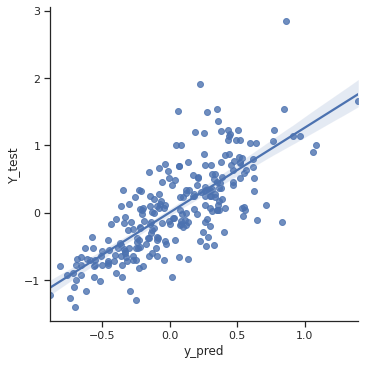

2
(999, 513)
(250, 513)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=44)
Calculating Permutation Importances
250
2-fold :  54.0
3-fold :  70.8
5-fold :  88.4
gmfe :  2.184585977678114
mfe :  1.3011910164252294
bias :  0.04237095557040191
rmse  0.4434776655483794
r2  0.5292978180552472


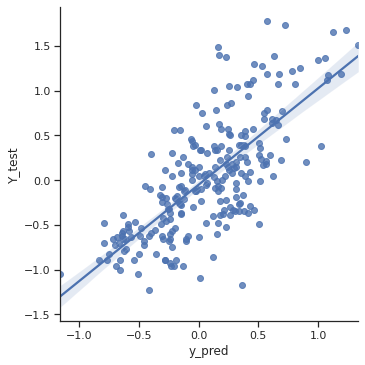

3
(999, 513)
(250, 513)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=44)
Calculating Permutation Importances
250
2-fold :  60.4
3-fold :  77.2
5-fold :  92.4
gmfe :  2.0492672965335696
mfe :  1.2685988637930499
bias :  0.036396718694246016
rmse  0.41748749720299927
r2  0.5214859175783801


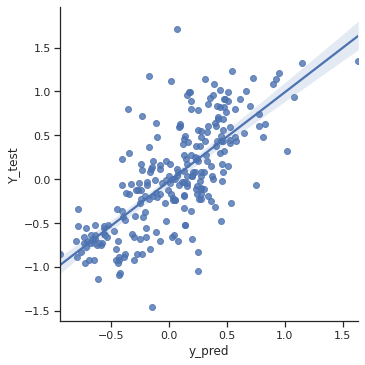

4
(1000, 513)
(249, 513)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=44)
Calculating Permutation Importances
249
2-fold :  62.24899598393574
3-fold :  80.72289156626506
5-fold :  91.56626506024097
gmfe :  2.010213361108018
mfe :  1.2564773572688461
bias :  0.0009624222259708715
rmse  0.4072307356042301
r2  0.5870395735889196
saving model


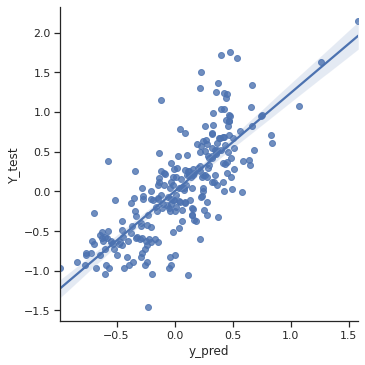

0
(999, 513)
(250, 513)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=45)
Calculating Permutation Importances
250
2-fold :  57.599999999999994
3-fold :  75.2
5-fold :  87.2
gmfe :  2.186798307773621
mfe :  1.2852245089093348
bias :  -0.0024124754845013946
rmse  0.46503301286351145
r2  0.4774486183607457


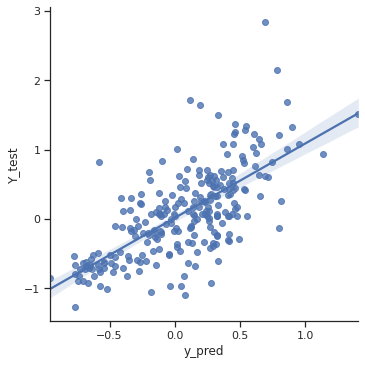

1
(999, 513)
(250, 513)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=45)
Calculating Permutation Importances
250
2-fold :  59.199999999999996
3-fold :  77.2
5-fold :  88.8
gmfe :  2.0600927060992946
mfe :  1.275996797716559
bias :  0.027072478997364202
rmse  0.4218417573329201
r2  0.49572282319831196


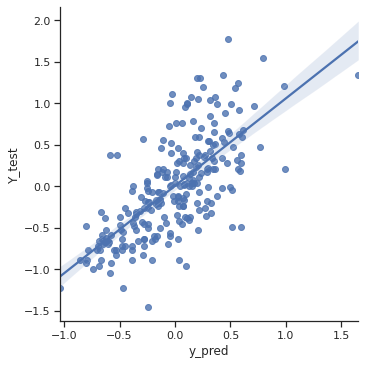

2
(999, 513)
(250, 513)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=45)
Calculating Permutation Importances
250
2-fold :  56.8
3-fold :  74.4
5-fold :  87.6
gmfe :  2.24126836841488
mfe :  1.2887491962315802
bias :  0.016685434374403098
rmse  0.4746370354990672
r2  0.5066909998041287


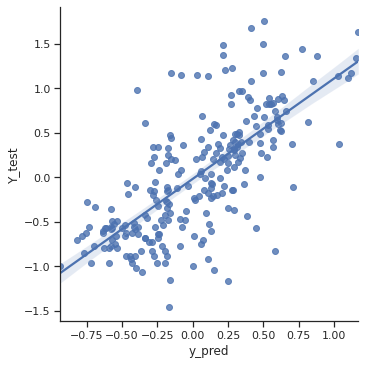

3
(999, 513)
(250, 513)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=45)
Calculating Permutation Importances
250
2-fold :  56.00000000000001
3-fold :  74.4
5-fold :  88.8
gmfe :  2.142207795121684
mfe :  1.304161703043862
bias :  0.11781945077463796
rmse  0.4281764697157531
r2  0.5348016895346621


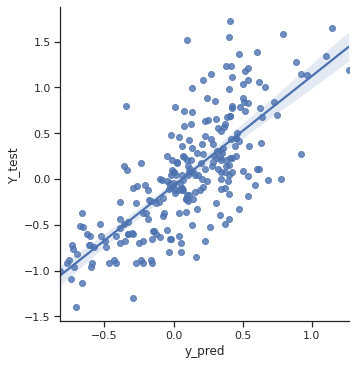

4
(1000, 513)
(249, 513)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=45)
Calculating Permutation Importances
249
2-fold :  58.63453815261044
3-fold :  76.70682730923694
5-fold :  91.96787148594377
gmfe :  2.0381408475728806
mfe :  1.2738333357164071
bias :  0.03258244836852697
rmse  0.40349438461828907
r2  0.6154937347088466


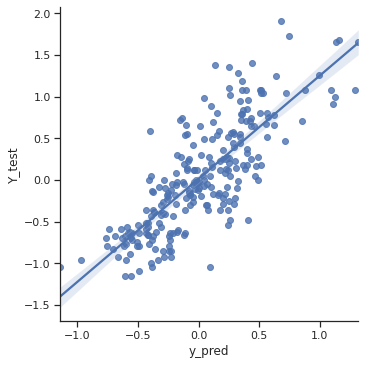

0
(999, 513)
(250, 513)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_estimators=300, n_jobs=30,
                      random_state=46)
Calculating Permutation Importances
250
2-fold :  58.4
3-fold :  77.60000000000001
5-fold :  88.4
gmfe :  2.128572402542035
mfe :  1.2907602042491106
bias :  0.024394245421127655
rmse  0.4316838377585167
r2  0.5225818400308314


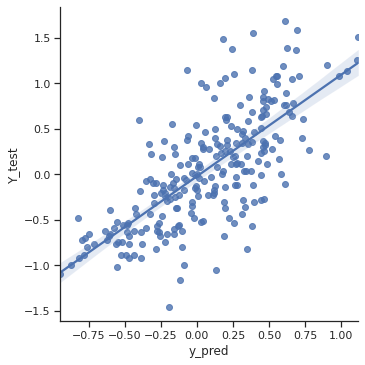

1
(999, 513)
(250, 513)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=46)
Calculating Permutation Importances
250
2-fold :  60.8
3-fold :  75.6
5-fold :  90.4
gmfe :  2.102079622190391
mfe :  1.2701407423182387
bias :  0.07092860691973224
rmse  0.4354229714895923
r2  0.5523078133134277


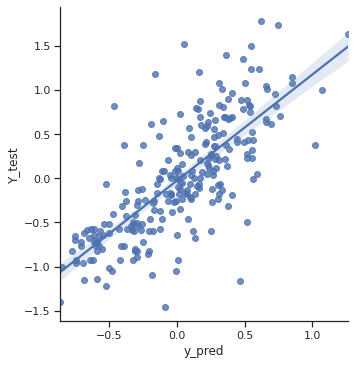

2
(999, 513)
(250, 513)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=46)
Calculating Permutation Importances
250
2-fold :  59.599999999999994
3-fold :  76.8
5-fold :  88.8
gmfe :  2.086363166231905
mfe :  1.263652000137912
bias :  0.016752114416902497
rmse  0.4310949677061644
r2  0.5418601348803751


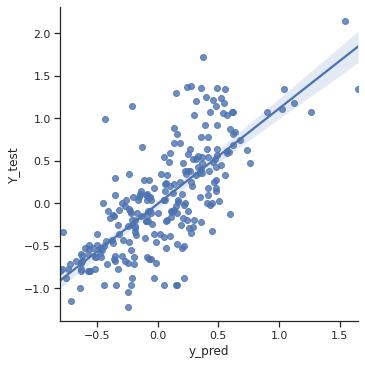

3
(999, 513)
(250, 513)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=46)
Calculating Permutation Importances
250
2-fold :  51.6
3-fold :  73.6
5-fold :  91.60000000000001
gmfe :  2.1807640807413864
mfe :  1.309562195526929
bias :  -0.013316391158215118
rmse  0.4341131730519815
r2  0.5556869700333427


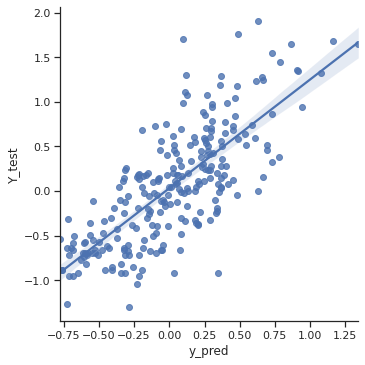

4
(1000, 513)
(249, 513)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=46)
Calculating Permutation Importances
249
2-fold :  58.23293172690763
3-fold :  75.90361445783132
5-fold :  90.36144578313254
gmfe :  2.1318534193363905
mfe :  1.2955004314002434
bias :  0.05593319439773793
rmse  0.43704148608078086
r2  0.5235828213032712


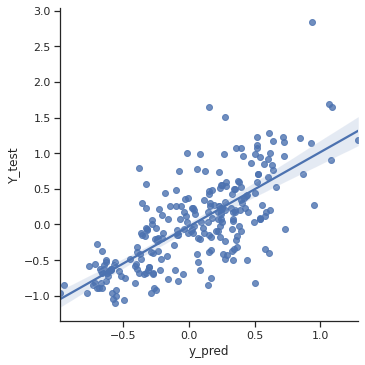

human_CL_mL_min_kg
0
(1024, 513)
(257, 513)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=42)
Calculating Permutation Importances
257
2-fold :  48.63813229571984
3-fold :  72.76264591439688
5-fold :  84.43579766536965
gmfe :  2.5091436897727464
mfe :  1.362647229083076
bias :  -0.1968026384375312
rmse  0.5584628801972371
r2  0.3161374333113103
saving model


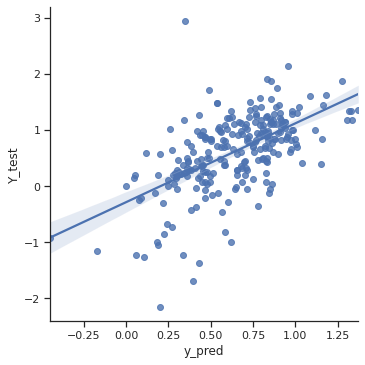

1
(1025, 513)
(256, 513)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_estimators=300, n_jobs=30,
                      random_state=42)
Calculating Permutation Importances
256
2-fold :  50.0
3-fold :  71.09375
5-fold :  85.9375
gmfe :  2.3966840157973093
mfe :  1.3502407279548454
bias :  -0.3982219593127876
rmse  0.5144361929164882
r2  0.34855478986865285
saving model


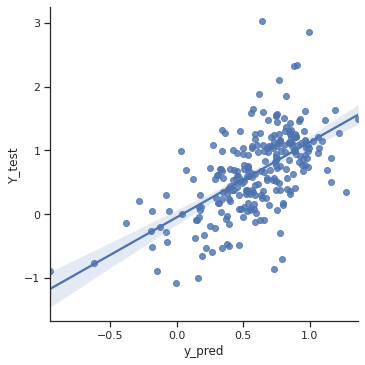

2
(1025, 513)
(256, 513)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=42)
Calculating Permutation Importances
256
2-fold :  52.734375
3-fold :  71.875
5-fold :  85.15625
gmfe :  2.431920907660637
mfe :  1.3350659614659273
bias :  -0.5100259071862197
rmse  0.5220034982210665
r2  0.24506716847490517


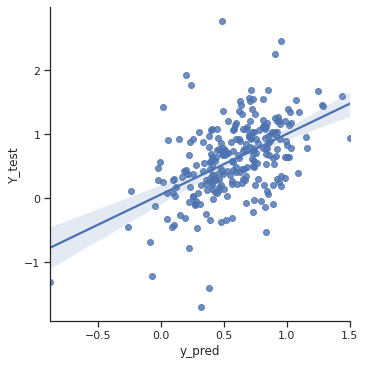

3
(1025, 513)
(256, 513)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=42)
Calculating Permutation Importances
256
2-fold :  52.34375
3-fold :  66.796875
5-fold :  87.5
gmfe :  2.4363816723525797
mfe :  1.3273476293291926
bias :  -0.44259114075305916
rmse  0.5268615565234388
r2  0.3584129019280652


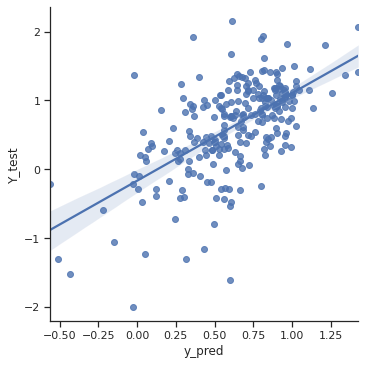

4
(1025, 513)
(256, 513)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=42)
Calculating Permutation Importances
256
2-fold :  48.828125
3-fold :  66.796875
5-fold :  81.640625
gmfe :  2.6696199949184893
mfe :  1.3659034695928811
bias :  -0.17962448535030417
rmse  0.5976942101480117
r2  0.2019392940703968


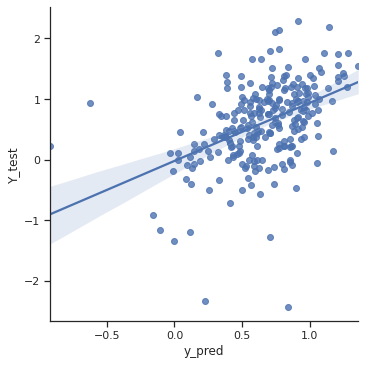

0
(1024, 513)
(257, 513)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_estimators=300, n_jobs=30,
                      random_state=43)
Calculating Permutation Importances
257
2-fold :  51.36186770428015
3-fold :  66.53696498054474
5-fold :  81.32295719844358
gmfe :  2.6886657407182875
mfe :  1.3315725273868728
bias :  0.0140022355815268
rmse  0.6151170861298777
r2  0.25364023183267126


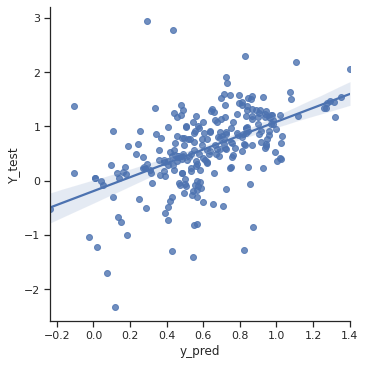

1
(1025, 513)
(256, 513)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=43)
Calculating Permutation Importances
256
2-fold :  41.796875
3-fold :  65.234375
5-fold :  82.421875
gmfe :  2.780916755445236
mfe :  1.3969305005398291
bias :  -0.259453389938352
rmse  0.6015735828530161
r2  0.27687676537588


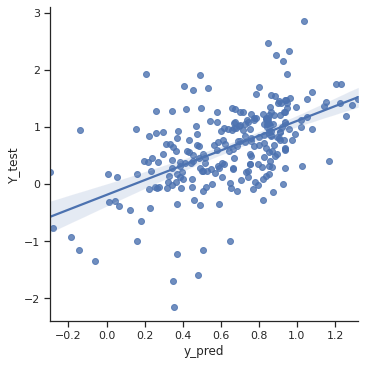

2
(1025, 513)
(256, 513)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=43)
Calculating Permutation Importances
256
2-fold :  47.65625
3-fold :  69.921875
5-fold :  85.15625
gmfe :  2.419058348578491
mfe :  1.3676902169665914
bias :  -0.33950345003160365
rmse  0.50230099587989
r2  0.30177436579350503


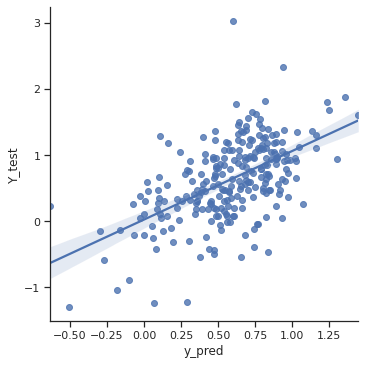

3
(1025, 513)
(256, 513)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=43)
Calculating Permutation Importances
256
2-fold :  55.078125
3-fold :  75.390625
5-fold :  85.9375
gmfe :  2.343329559127656
mfe :  1.310308204176423
bias :  -0.4124457192583043
rmse  0.4930751483103771
r2  0.3327076120897492
saving model


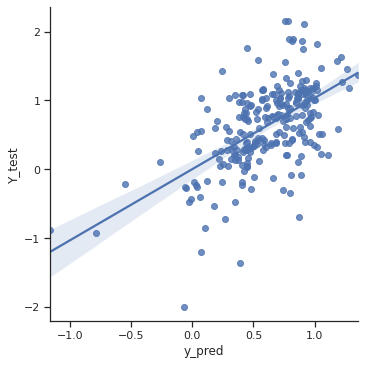

4
(1025, 513)
(256, 513)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_estimators=300, n_jobs=30,
                      random_state=43)
Calculating Permutation Importances
256
2-fold :  53.90625
3-fold :  70.703125
5-fold :  86.71875
gmfe :  2.2799565959334918
mfe :  1.3085088390949022
bias :  -0.2348283973627584
rmse  0.49681358975737955
r2  0.33285862151821155
saving model


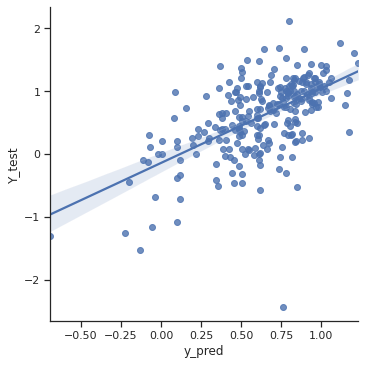

0
(1024, 513)
(257, 513)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=44)
Calculating Permutation Importances
257
2-fold :  54.86381322957199
3-fold :  72.37354085603113
5-fold :  87.15953307392996
gmfe :  2.3420668635417705
mfe :  1.334501078021886
bias :  -0.4774139776476449
rmse  0.4986746415979543
r2  0.38484548994272605


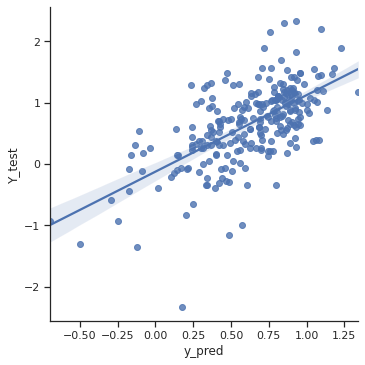

1
(1025, 513)
(256, 513)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=44)
Calculating Permutation Importances
256
2-fold :  53.515625
3-fold :  75.0
5-fold :  86.71875
gmfe :  2.3892388338043347
mfe :  1.3093944625311662
bias :  -0.5708086506787011
rmse  0.5287328897706691
r2  0.2911254211673956


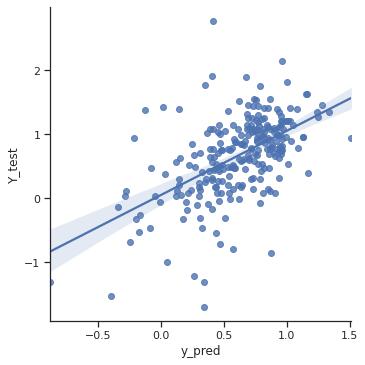

2
(1025, 513)
(256, 513)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=44)
Calculating Permutation Importances
256
2-fold :  54.6875
3-fold :  70.3125
5-fold :  81.640625
gmfe :  2.512605137671164
mfe :  1.3197703963223038
bias :  0.21798595046316105
rmse  0.5553189223819935
r2  0.3182115444615847


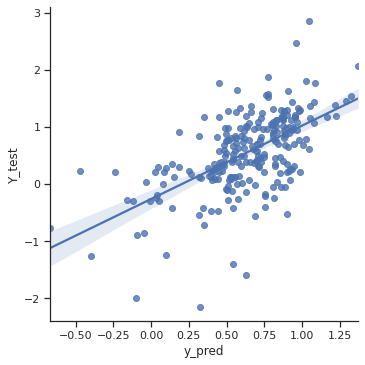

3
(1025, 513)
(256, 513)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_jobs=30, random_state=44)
Calculating Permutation Importances
256
2-fold :  48.4375
3-fold :  66.796875
5-fold :  82.8125
gmfe :  2.6483437365172784
mfe :  1.373911164192092
bias :  -0.11003937937248498
rmse  0.5898265559300931
r2  0.24001354236009664


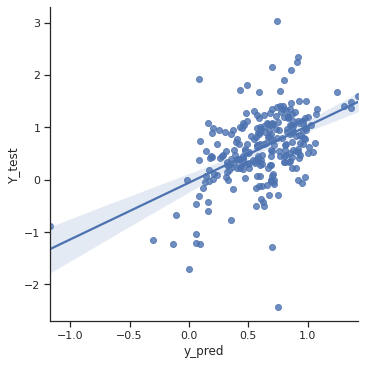

4
(1025, 513)
(256, 513)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=44)
Calculating Permutation Importances
256
2-fold :  51.5625
3-fold :  68.75
5-fold :  84.765625
gmfe :  2.418175030769535
mfe :  1.343256914182088
bias :  -0.43791741874862034
rmse  0.5134920542922188
r2  0.3206056401558539


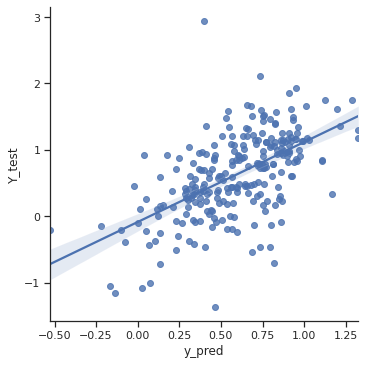

0
(1024, 513)
(257, 513)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=45)
Calculating Permutation Importances
257
2-fold :  47.081712062256805
3-fold :  71.98443579766537
5-fold :  88.715953307393
gmfe :  2.347744784086216
mfe :  1.3991336503356957
bias :  -0.5597819423298693
rmse  0.4662047326625066
r2  0.3474569141873247


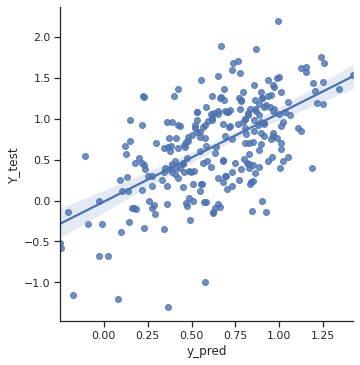

1
(1025, 513)
(256, 513)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_jobs=30, random_state=45)
Calculating Permutation Importances
256
2-fold :  50.390625
3-fold :  69.140625
5-fold :  82.8125
gmfe :  2.4268794201064092
mfe :  1.349278407267721
bias :  0.2801709187932414
rmse  0.5063313452134154
r2  0.31276212321513563


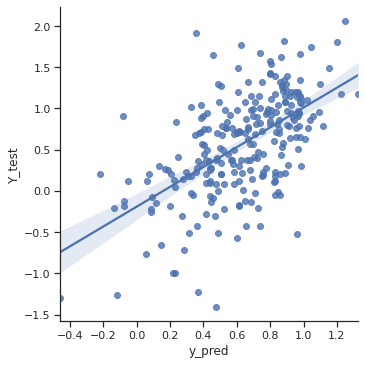

2
(1025, 513)
(256, 513)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=45)
Calculating Permutation Importances
256
2-fold :  49.21875
3-fold :  70.3125
5-fold :  83.203125
gmfe :  2.545120409827726
mfe :  1.3571524680883085
bias :  -0.7862646600656389
rmse  0.5783565558402862
r2  0.24776902226041675


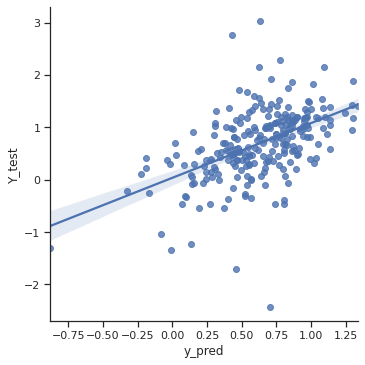

3
(1025, 513)
(256, 513)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=45)
Calculating Permutation Importances
256
2-fold :  52.34375
3-fold :  71.09375
5-fold :  85.15625
gmfe :  2.452718263556678
mfe :  1.320667890047976
bias :  -0.05874727447041783
rmse  0.5458530289688961
r2  0.2727860738629282


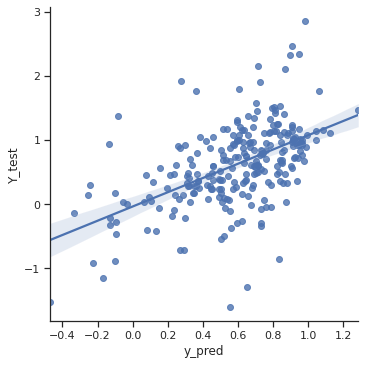

4
(1025, 513)
(256, 513)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=45)
Calculating Permutation Importances
256
2-fold :  50.390625
3-fold :  69.140625
5-fold :  82.03125
gmfe :  2.634951703389939
mfe :  1.3457052464328891
bias :  -0.09587129464316102
rmse  0.6056159634046101
r2  0.31126396143942514


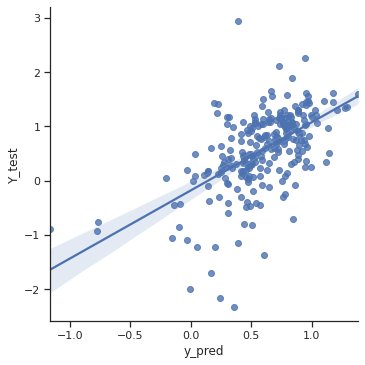

0
(1024, 513)
(257, 513)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_jobs=30, random_state=46)
Calculating Permutation Importances
257
2-fold :  51.36186770428015
3-fold :  69.26070038910505
5-fold :  85.21400778210116
gmfe :  2.4611795708021242
mfe :  1.3358148380606845
bias :  -0.8571133944144114
rmse  0.548921353961925
r2  0.25177454124015186


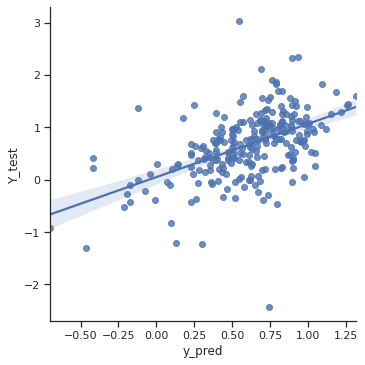

1
(1025, 513)
(256, 513)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=46)
Calculating Permutation Importances
256
2-fold :  46.875
3-fold :  65.625
5-fold :  82.8125
gmfe :  2.722672011032783
mfe :  1.3691747365469902
bias :  -0.17100587253184507
rmse  0.5959808022337517
r2  0.3074944711226498


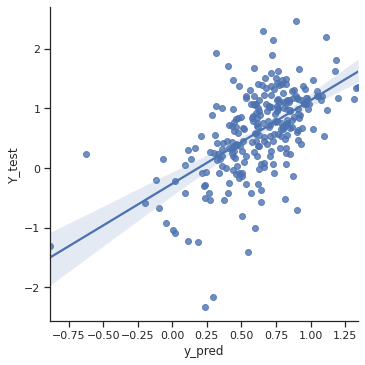

2
(1025, 513)
(256, 513)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=46)
Calculating Permutation Importances
256
2-fold :  55.078125
3-fold :  71.09375
5-fold :  81.640625
gmfe :  2.4722688710685463
mfe :  1.3203170162029658
bias :  0.1367232147565508
rmse  0.5629776628000513
r2  0.27862453430671474


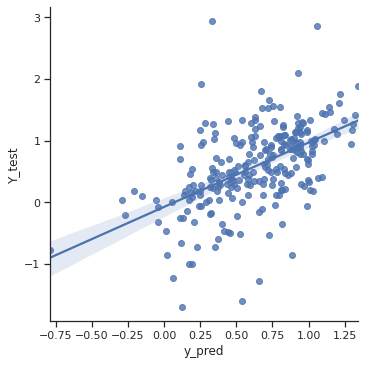

3
(1025, 513)
(256, 513)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=46)
Calculating Permutation Importances
256
2-fold :  48.4375
3-fold :  69.140625
5-fold :  85.546875
gmfe :  2.480471222615323
mfe :  1.3706312013979618
bias :  -0.04416077602817592
rmse  0.5273098007876483
r2  0.3336216400553583


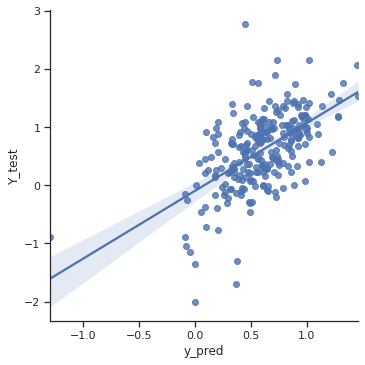

4
(1025, 513)
(256, 513)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=46)
Calculating Permutation Importances
256
2-fold :  50.78125
3-fold :  75.390625
5-fold :  89.84375
gmfe :  2.230280723669598
mfe :  1.347598709762337
bias :  -0.48390936699158016
rmse  0.45548280248707435
r2  0.3671426408241103
saving model


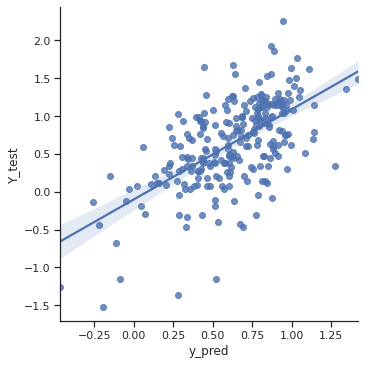

human_fup
0
(703, 513)
(176, 513)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=42)
Calculating Permutation Importances
176
2-fold :  52.84090909090909
3-fold :  64.77272727272727
5-fold :  73.86363636363636
gmfe :  3.101725512914276
mfe :  1.324709584430887
bias :  0.04742289124851949
rmse  0.21006485170327302
r2  0.6423812529365569
saving model


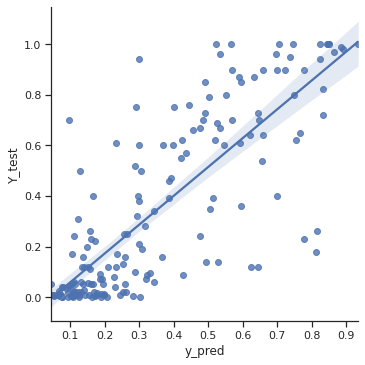

1
(703, 513)
(176, 513)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=42)
Calculating Permutation Importances
176
2-fold :  58.52272727272727
3-fold :  71.02272727272727
5-fold :  79.54545454545455
gmfe :  2.7207240931879264
mfe :  1.2723312698142606
bias :  0.04962140972224204
rmse  0.19545898627381939
r2  0.6229543816098334
saving model


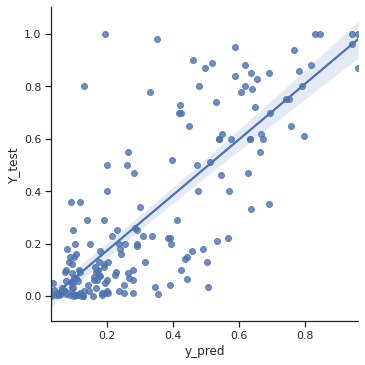

2
(703, 513)
(176, 513)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_estimators=300, n_jobs=30,
                      random_state=42)
Calculating Permutation Importances
176
2-fold :  59.65909090909091
3-fold :  71.5909090909091
5-fold :  82.95454545454545
gmfe :  2.5012666048683676
mfe :  1.242468313613838
bias :  -0.0009980300055792146
rmse  0.22947040486592632
r2  0.5617411972895164
saving model


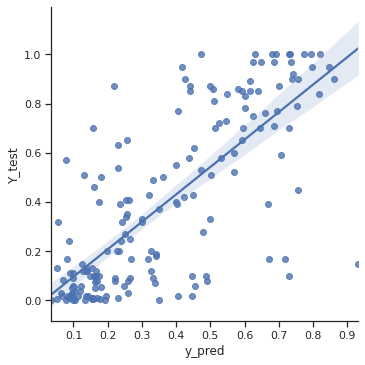

3
(703, 513)
(176, 513)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=42)
Calculating Permutation Importances
176
2-fold :  55.68181818181818
3-fold :  68.18181818181817
5-fold :  77.8409090909091
gmfe :  2.729337625516605
mfe :  1.2813074267541846
bias :  0.04109392763924181
rmse  0.2146424684201523
r2  0.6158361713580558


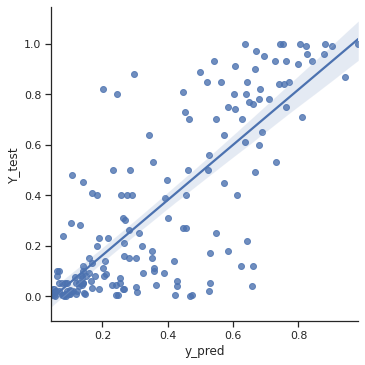

4
(704, 513)
(175, 513)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=42)
Calculating Permutation Importances
175
2-fold :  54.85714285714286
3-fold :  66.28571428571428
5-fold :  76.57142857142857
gmfe :  2.7139470897703606
mfe :  1.2637948963280123
bias :  0.04455627679473295
rmse  0.20038009826086126
r2  0.6441021101718705


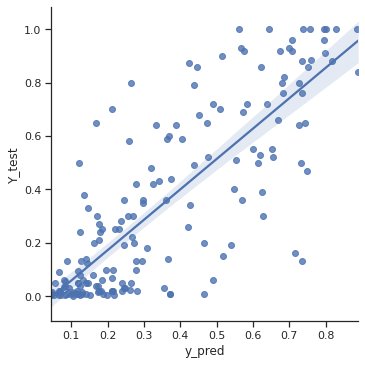

0
(703, 513)
(176, 513)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=43)
Calculating Permutation Importances
176
2-fold :  54.54545454545454
3-fold :  67.04545454545455
5-fold :  79.54545454545455
gmfe :  2.6652253929798366
mfe :  1.3073256298504745
bias :  0.04021368516193488
rmse  0.2213263823334039
r2  0.5732829556618364


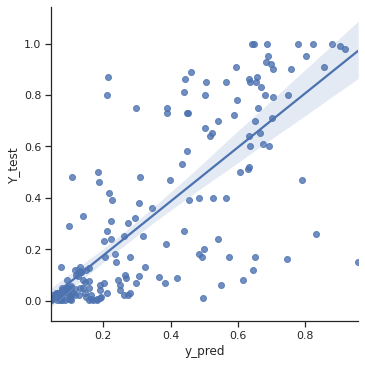

1
(703, 513)
(176, 513)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_estimators=300, n_jobs=30,
                      random_state=43)
Calculating Permutation Importances
176
2-fold :  57.38636363636363
3-fold :  65.9090909090909
5-fold :  77.8409090909091
gmfe :  2.691585796565892
mfe :  1.249999675217302
bias :  0.03810802510212591
rmse  0.19404548904769453
r2  0.6350719109621474


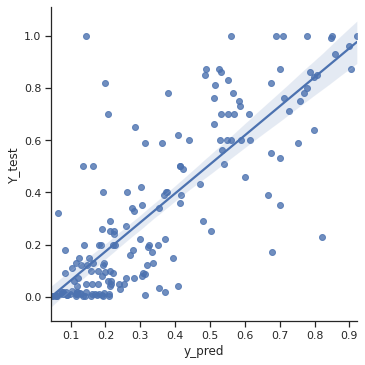

2
(703, 513)
(176, 513)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      min_samples_split=8, n_estimators=300, n_jobs=30,
                      random_state=43)
Calculating Permutation Importances
176
2-fold :  54.54545454545454
3-fold :  66.47727272727273
5-fold :  74.43181818181817
gmfe :  3.080212052047941
mfe :  1.2619026553058994
bias :  0.03858966518601728
rmse  0.2227706419274586
r2  0.636091745970844


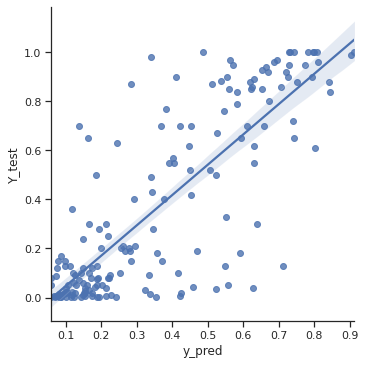

3
(703, 513)
(176, 513)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      min_samples_split=8, n_jobs=30, random_state=43)
Calculating Permutation Importances
176
2-fold :  53.40909090909091
3-fold :  68.18181818181817
5-fold :  77.27272727272727
gmfe :  2.9764450808825162
mfe :  1.3023784553650888
bias :  0.03103538698741483
rmse  0.23545797024982038
r2  0.5629420546016004


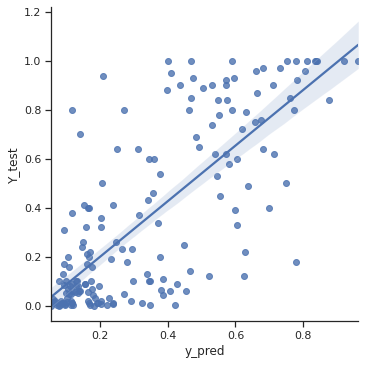

4
(704, 513)
(175, 513)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=43)
Calculating Permutation Importances
175
2-fold :  57.14285714285714
3-fold :  68.0
5-fold :  83.42857142857143
gmfe :  2.3849275537300625
mfe :  1.2648024755453722
bias :  0.033526156929181816
rmse  0.18486940517116757
r2  0.6508818182205474
saving model


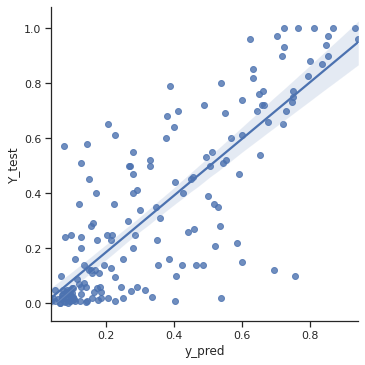

0
(703, 513)
(176, 513)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=44)
Calculating Permutation Importances
176
2-fold :  55.11363636363637
3-fold :  68.75
5-fold :  81.81818181818183
gmfe :  2.446364534868587
mfe :  1.2631068010393185
bias :  0.044205550582472684
rmse  0.20167031053093848
r2  0.6664319022947489


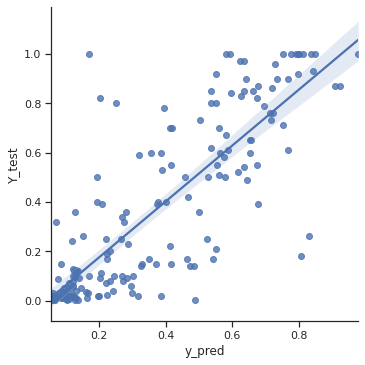

1
(703, 513)
(176, 513)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=44)
Calculating Permutation Importances
176
2-fold :  55.11363636363637
3-fold :  65.3409090909091
5-fold :  77.27272727272727
gmfe :  2.7533274565940715
mfe :  1.292736889052734
bias :  0.03499217666916511
rmse  0.21328500491362706
r2  0.5837150961774162


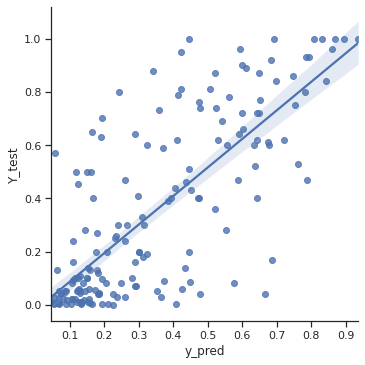

2
(703, 513)
(176, 513)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_jobs=30, random_state=44)
Calculating Permutation Importances
176
2-fold :  56.81818181818182
3-fold :  67.04545454545455
5-fold :  76.70454545454545
gmfe :  2.907832344722025
mfe :  1.2530535062074224
bias :  0.03300681328906087
rmse  0.20491251850582243
r2  0.6346006376864612


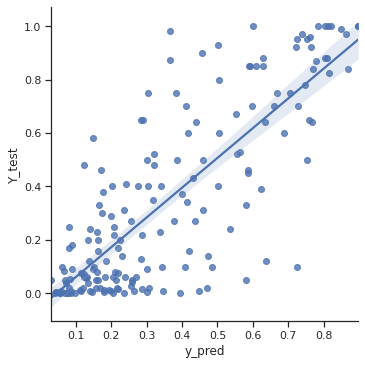

3
(703, 513)
(176, 513)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_jobs=30, random_state=44)
Calculating Permutation Importances
176
2-fold :  55.68181818181818
3-fold :  69.88636363636364
5-fold :  78.97727272727273
gmfe :  2.8143667537904666
mfe :  1.2717829771708928
bias :  0.03030399812730504
rmse  0.21485663348003592
r2  0.6279427021025987


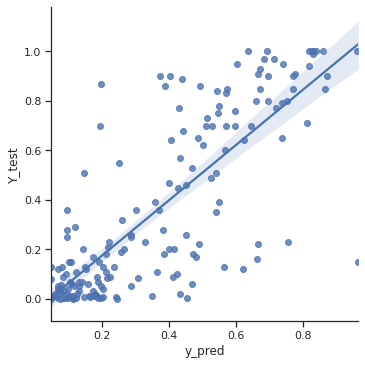

4
(704, 513)
(175, 513)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=44)
Calculating Permutation Importances
175
2-fold :  52.57142857142857
3-fold :  63.42857142857142
5-fold :  74.85714285714286
gmfe :  2.7323431620335454
mfe :  1.319204414153739
bias :  0.045622424632837874
rmse  0.20816834814357965
r2  0.602185947710768


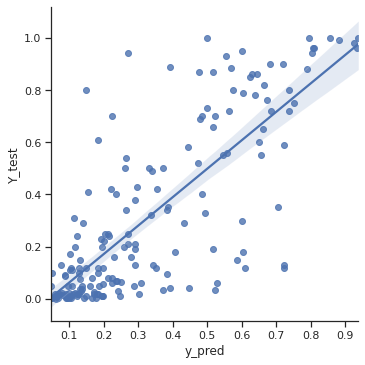

0
(703, 513)
(176, 513)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=45)
Calculating Permutation Importances
176
2-fold :  48.29545454545455
3-fold :  63.63636363636363
5-fold :  76.13636363636364
gmfe :  3.1882429426369927
mfe :  1.4190048615943496
bias :  0.060587600345807395
rmse  0.21681861955476867
r2  0.49758104192353914


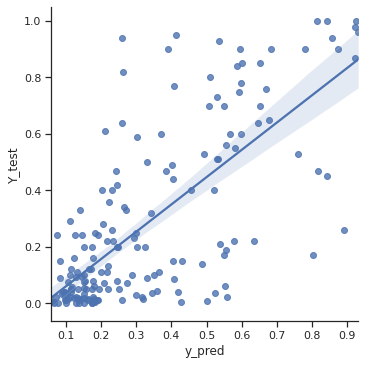

1
(703, 513)
(176, 513)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=45)
Calculating Permutation Importances
176
2-fold :  52.84090909090909
3-fold :  65.3409090909091
5-fold :  79.54545454545455
gmfe :  2.681459002041998
mfe :  1.3009233243699505
bias :  0.029424260080881563
rmse  0.23443034831479892
r2  0.5250854835259997


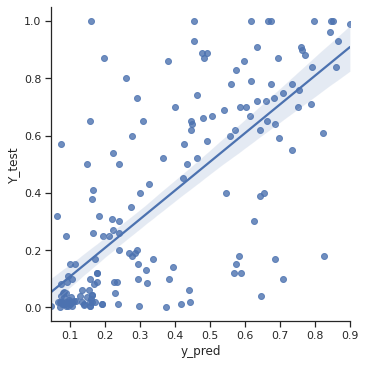

2
(703, 513)
(176, 513)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_estimators=300, n_jobs=30,
                      random_state=45)
Calculating Permutation Importances
176
2-fold :  57.38636363636363
3-fold :  68.75
5-fold :  79.54545454545455
gmfe :  2.656290951204418
mfe :  1.2559924739767185
bias :  0.02023168006287958
rmse  0.20802395115612995
r2  0.6577960210339261


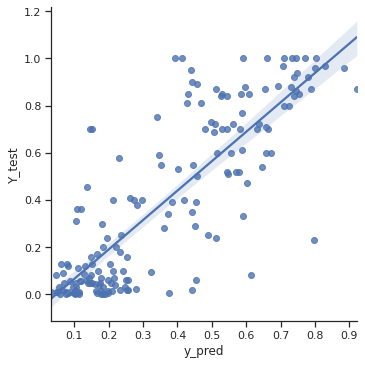

3
(703, 513)
(176, 513)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=45)
Calculating Permutation Importances
176
2-fold :  59.65909090909091
3-fold :  70.45454545454545
5-fold :  78.97727272727273
gmfe :  2.603822332188135
mfe :  1.2350591049458701
bias :  0.041030788453937435
rmse  0.19931742781719564
r2  0.6506688916362289


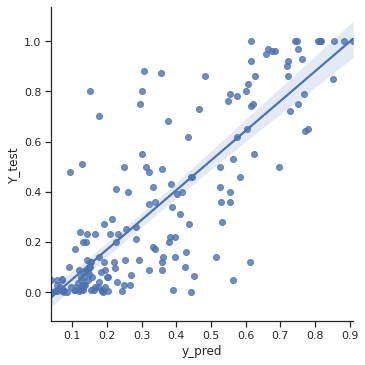

4
(704, 513)
(175, 513)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=45)
Calculating Permutation Importances
175
2-fold :  58.857142857142854
3-fold :  73.14285714285714
5-fold :  78.85714285714286
gmfe :  2.6921683433786945
mfe :  1.2174710200538588
bias :  0.03307398610290846
rmse  0.1976444698466343
r2  0.6859717301833912


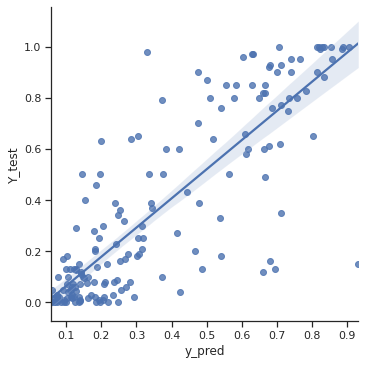

0
(703, 513)
(176, 513)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=46)
Calculating Permutation Importances
176
2-fold :  53.97727272727273
3-fold :  63.63636363636363
5-fold :  75.0
gmfe :  3.0186895194652825
mfe :  1.2963064363934058
bias :  0.048254729920383474
rmse  0.225382936289421
r2  0.5847671850656002


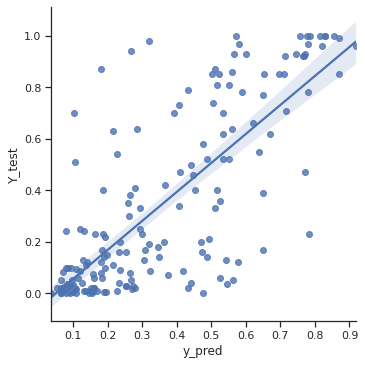

1
(703, 513)
(176, 513)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=46)
Calculating Permutation Importances
176
2-fold :  56.25
3-fold :  69.88636363636364
5-fold :  81.25
gmfe :  2.6411356540561366
mfe :  1.2497552556373628
bias :  0.01886740893993099
rmse  0.2003538758813578
r2  0.6356755845223102


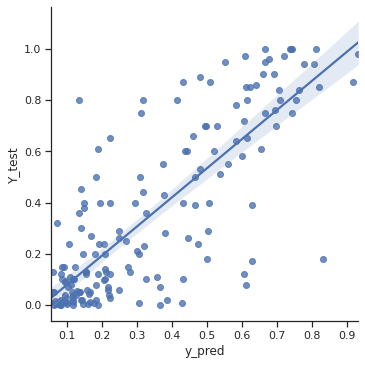

2
(703, 513)
(176, 513)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=46)
Calculating Permutation Importances
176
2-fold :  52.27272727272727
3-fold :  63.06818181818182
5-fold :  78.4090909090909
gmfe :  2.782313833310091
mfe :  1.3295566695734706
bias :  0.05215886309815648
rmse  0.21972954278763998
r2  0.5971071929158495


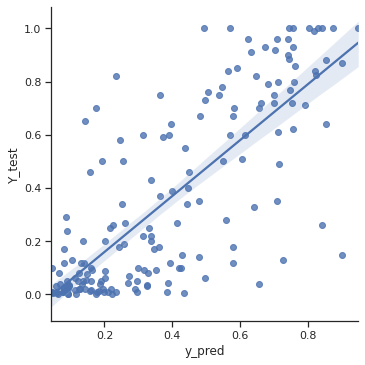

3
(703, 513)
(176, 513)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=46)
Calculating Permutation Importances
176
2-fold :  60.22727272727273
3-fold :  69.88636363636364
5-fold :  81.25
gmfe :  2.5976439003678364
mfe :  1.2212080947849566
bias :  0.03655732913097366
rmse  0.1812372549409785
r2  0.6958249482569577


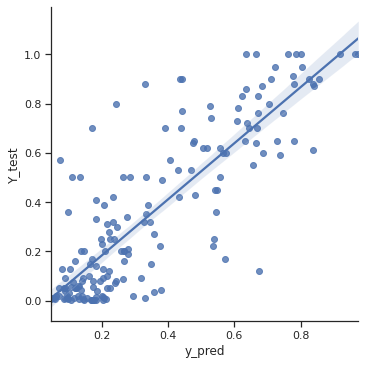

4
(704, 513)
(175, 513)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_jobs=30, random_state=46)
Calculating Permutation Importances
175
2-fold :  54.85714285714286
3-fold :  64.0
5-fold :  77.14285714285715
gmfe :  2.702276505425835
mfe :  1.311500429950863
bias :  0.03612845859134873
rmse  0.21492176987322795
r2  0.6155826336234347


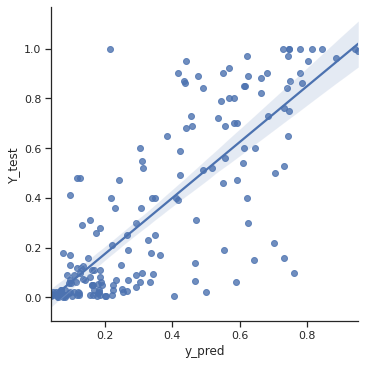

human_mrt
0
(994, 513)
(249, 513)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      n_estimators=200, n_jobs=30, random_state=42)
Calculating Permutation Importances
249
2-fold :  48.59437751004016
3-fold :  70.28112449799197
5-fold :  81.52610441767068
gmfe :  2.534635696485652
mfe :  1.3735054429867324
bias :  -0.05367387855668948
rmse  0.5323010797174165
r2  0.2635913813507521
saving model


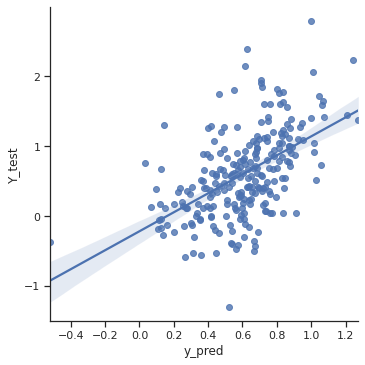

1
(994, 513)
(249, 513)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=42)
Calculating Permutation Importances
249
2-fold :  49.39759036144578
3-fold :  72.28915662650603
5-fold :  85.94377510040161
gmfe :  2.453621738423665
mfe :  1.3574117063762228
bias :  -0.2140254799301311
rmse  0.5232193211125106
r2  0.24600864252843058
saving model


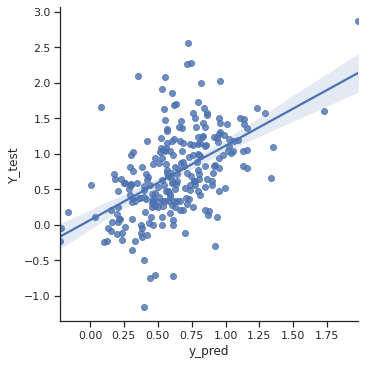

2
(994, 513)
(249, 513)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_estimators=200, n_jobs=30,
                      random_state=42)
Calculating Permutation Importances
249
2-fold :  52.610441767068274
3-fold :  71.4859437751004
5-fold :  83.13253012048193
gmfe :  2.5432241794826984
mfe :  1.3391403081817168
bias :  0.02067802375559169
rmse  0.5611906013009197
r2  0.28096444434551315


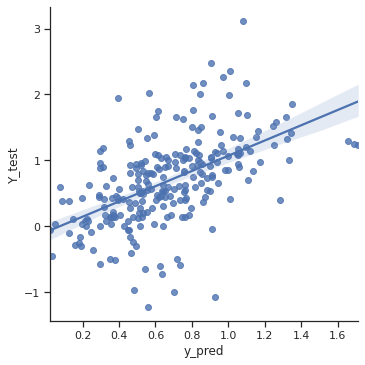

3
(995, 513)
(248, 513)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=42)
Calculating Permutation Importances
248
2-fold :  51.61290322580645
3-fold :  69.75806451612904
5-fold :  81.04838709677419
gmfe :  2.5686449685410055
mfe :  1.3445107909416492
bias :  -0.021853995167084417
rmse  0.5898256889487141
r2  0.2748572863890427


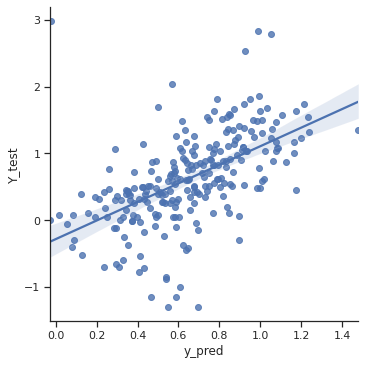

4
(995, 513)
(248, 513)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      n_estimators=300, n_jobs=30, random_state=42)
Calculating Permutation Importances
248
2-fold :  49.596774193548384
3-fold :  68.95161290322581
5-fold :  81.45161290322581
gmfe :  2.4964918685907174
mfe :  1.364019831336782
bias :  0.5301935287768575
rmse  0.5340364936515545
r2  0.24962331360384582


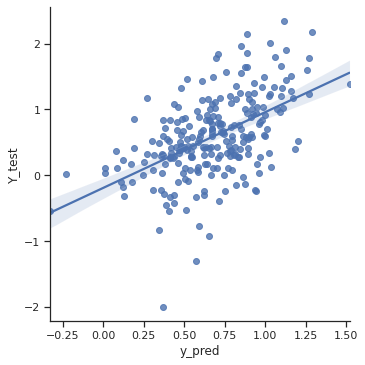

0
(994, 513)
(249, 513)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=43)
Calculating Permutation Importances
249
2-fold :  47.791164658634536
3-fold :  71.4859437751004
5-fold :  84.73895582329317
gmfe :  2.5214612216467045
mfe :  1.3849323423495765
bias :  -0.15138785352340722
rmse  0.5473271984270639
r2  0.2726769176347952


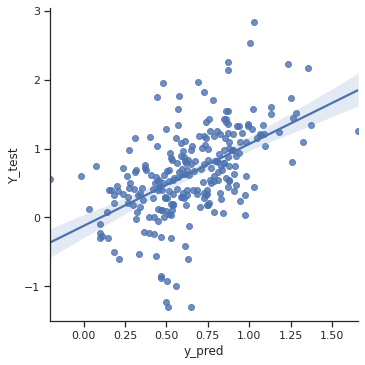

1
(994, 513)
(249, 513)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=43)
Calculating Permutation Importances
249
2-fold :  45.38152610441767
3-fold :  66.66666666666666
5-fold :  81.52610441767068
gmfe :  2.7113612845032615
mfe :  1.3953098344262214
bias :  0.038067003123954724
rmse  0.5921951132598342
r2  0.2728492757456762


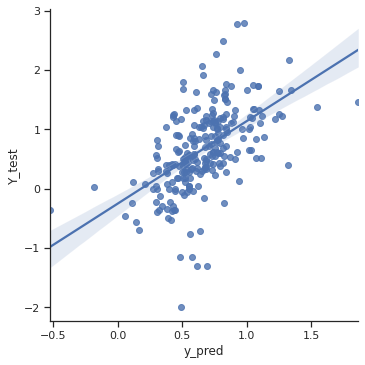

2
(994, 513)
(249, 513)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=43)
Calculating Permutation Importances
249
2-fold :  48.59437751004016
3-fold :  68.27309236947792
5-fold :  84.33734939759037
gmfe :  2.4571855408803973
mfe :  1.3721099037044222
bias :  0.03200547842298551
rmse  0.5162380378509995
r2  0.28936620016414616


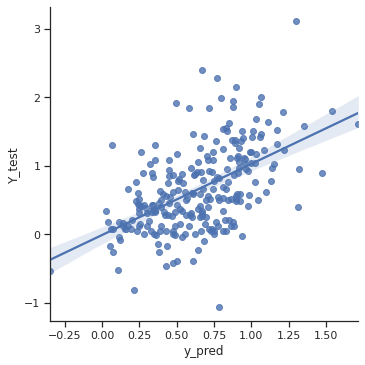

3
(995, 513)
(248, 513)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=43)
Calculating Permutation Importances
248
2-fold :  50.806451612903224
3-fold :  70.56451612903226
5-fold :  80.64516129032258
gmfe :  2.5790855892265308
mfe :  1.3467017020099057
bias :  0.08747477378347801
rmse  0.5730217812130257
r2  0.24381186726376258


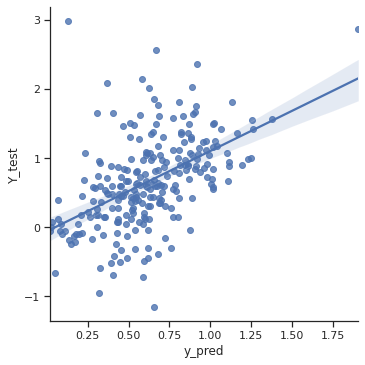

4
(995, 513)
(248, 513)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_estimators=300, n_jobs=30,
                      random_state=43)
Calculating Permutation Importances
248
2-fold :  54.43548387096774
3-fold :  73.79032258064517
5-fold :  87.90322580645162
gmfe :  2.2575645910808366
mfe :  1.3249471614847987
bias :  0.3506408863943511
rmse  0.47594982867642416
r2  0.3567282919762418
saving model


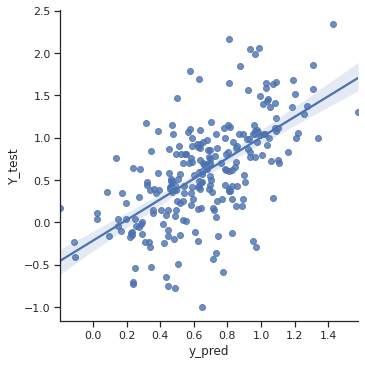

0
(994, 513)
(249, 513)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_estimators=200, n_jobs=30,
                      random_state=44)
Calculating Permutation Importances
249
2-fold :  48.59437751004016
3-fold :  71.4859437751004
5-fold :  86.74698795180723
gmfe :  2.3801680444929056
mfe :  1.3600844016950795
bias :  0.014102398167231911
rmse  0.5038089909465775
r2  0.27882365802713827


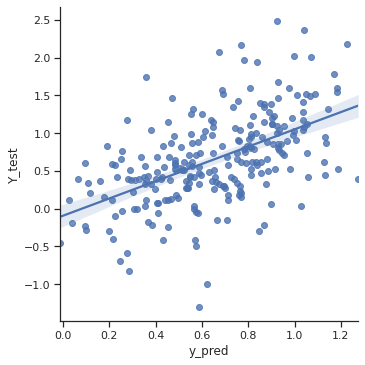

1
(994, 513)
(249, 513)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=44)
Calculating Permutation Importances
249
2-fold :  55.82329317269076
3-fold :  70.68273092369478
5-fold :  82.32931726907631
gmfe :  2.5810598911579192
mfe :  1.2900190355743046
bias :  0.28659700275661404
rmse  0.5910232027426677
r2  0.27120684878720214


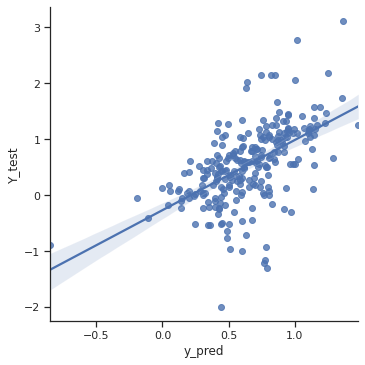

2
(994, 513)
(249, 513)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=44)
Calculating Permutation Importances
249
2-fold :  46.1847389558233
3-fold :  71.8875502008032
5-fold :  83.53413654618474
gmfe :  2.4864642367029695
mfe :  1.387646761463182
bias :  0.02253826435152817
rmse  0.5272764587300026
r2  0.2823160438606146


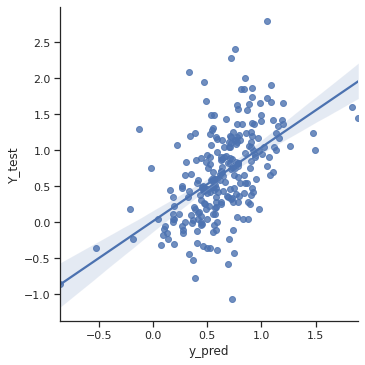

3
(995, 513)
(248, 513)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=44)
Calculating Permutation Importances
248
2-fold :  52.41935483870967
3-fold :  68.14516129032258
5-fold :  81.85483870967742
gmfe :  2.5512725329312085
mfe :  1.3253605439811469
bias :  0.23112567096745096
rmse  0.5482899980554133
r2  0.23231021477755842


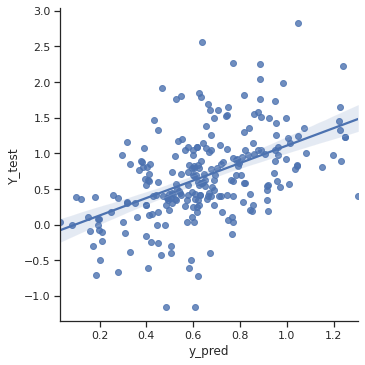

4
(995, 513)
(248, 513)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=44)
Calculating Permutation Importances
248
2-fold :  48.38709677419355
3-fold :  71.7741935483871
5-fold :  83.06451612903226
gmfe :  2.4785233043462647
mfe :  1.3589332284109632
bias :  -0.1961634353499495
rmse  0.5421863296140615
r2  0.3240457581042666


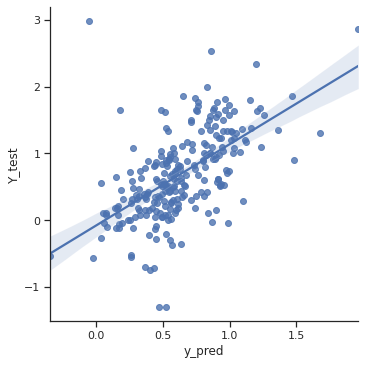

0
(994, 513)
(249, 513)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=45)
Calculating Permutation Importances
249
2-fold :  51.00401606425703
3-fold :  69.07630522088354
5-fold :  84.73895582329317
gmfe :  2.5065732641483147
mfe :  1.343986277024261
bias :  -0.5622214025344459
rmse  0.5531390737259426
r2  0.23810200534617854


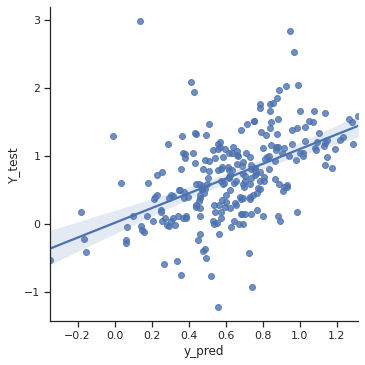

1
(994, 513)
(249, 513)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=45)
Calculating Permutation Importances
249
2-fold :  47.389558232931726
3-fold :  69.07630522088354
5-fold :  81.52610441767068
gmfe :  2.7371039563754285
mfe :  1.3771305667683265
bias :  0.3150314182398597
rmse  0.5991696601429582
r2  0.2650928020711699


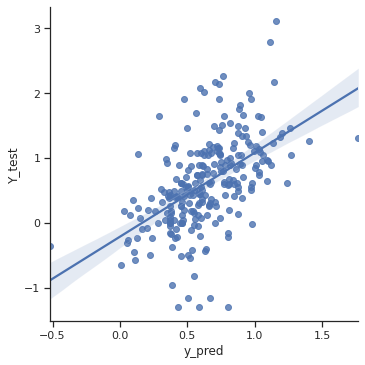

2
(994, 513)
(249, 513)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_estimators=300, n_jobs=30,
                      random_state=45)
Calculating Permutation Importances
249
2-fold :  53.01204819277109
3-fold :  72.28915662650603
5-fold :  84.73895582329317
gmfe :  2.410765326489514
mfe :  1.3196916148049254
bias :  -0.10696155640989602
rmse  0.5273573405552375
r2  0.309997746842003


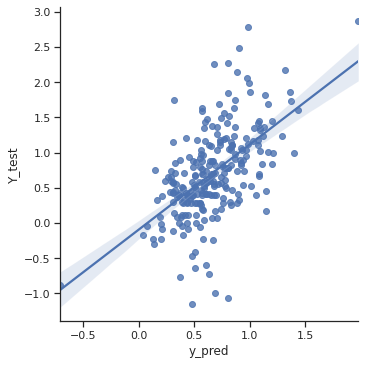

3
(995, 513)
(248, 513)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=45)
Calculating Permutation Importances
248
2-fold :  50.0
3-fold :  72.58064516129032
5-fold :  84.67741935483872
gmfe :  2.3909869527040977
mfe :  1.3511729739925011
bias :  -0.03811840904837749
rmse  0.4964375974021598
r2  0.3217136764775659


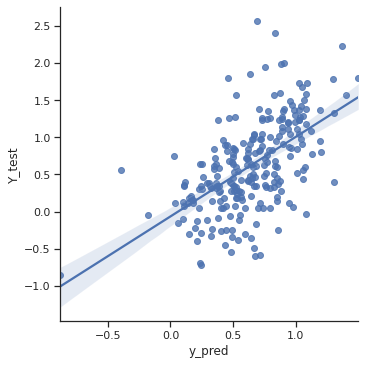

4
(995, 513)
(248, 513)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=45)
Calculating Permutation Importances
248
2-fold :  49.193548387096776
3-fold :  68.14516129032258
5-fold :  83.46774193548387
gmfe :  2.498820218720876
mfe :  1.3570861807785854
bias :  0.6214859675902459
rmse  0.5367831168727749
r2  0.26073174718548264


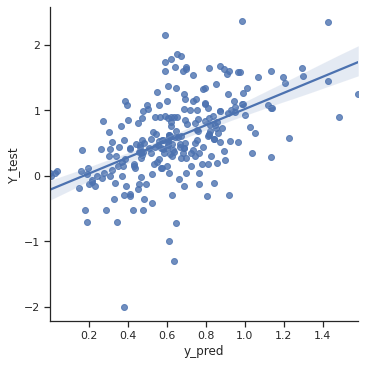

0
(994, 513)
(249, 513)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_estimators=300, n_jobs=30,
                      random_state=46)
Calculating Permutation Importances
249
2-fold :  48.19277108433735
3-fold :  69.87951807228916
5-fold :  81.12449799196787
gmfe :  2.6441421432884322
mfe :  1.3738393619953362
bias :  0.042773280619074594
rmse  0.5680814116753974
r2  0.2851338171643645


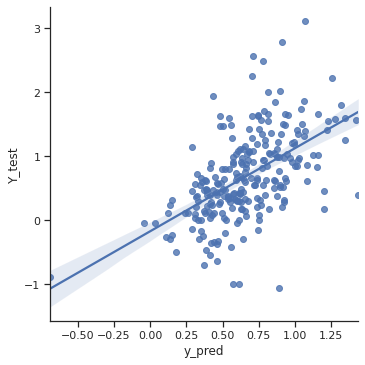

1
(994, 513)
(249, 513)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=46)
Calculating Permutation Importances
249
2-fold :  53.41365461847389
3-fold :  73.89558232931726
5-fold :  84.33734939759037
gmfe :  2.3548526743171307
mfe :  1.3259517284767555
bias :  0.048581974840986364
rmse  0.5037981629234214
r2  0.3469855290875502


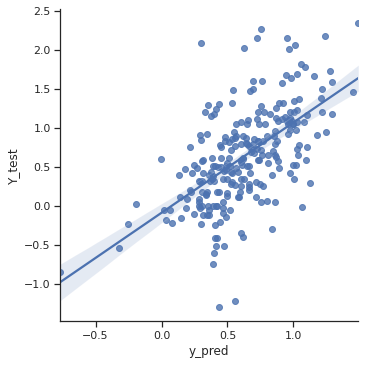

2
(994, 513)
(249, 513)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_jobs=30, random_state=46)
Calculating Permutation Importances
249
2-fold :  54.61847389558233
3-fold :  74.29718875502009
5-fold :  86.74698795180723
gmfe :  2.308393684160005
mfe :  1.2995516492004684
bias :  -0.018321378000097255
rmse  0.5024234045713462
r2  0.31951314001608067


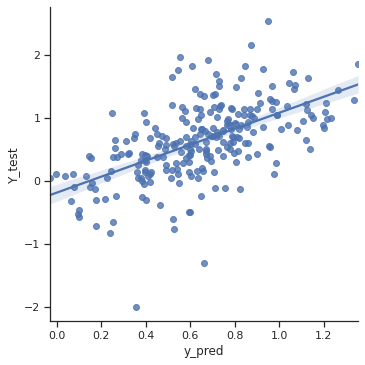

3
(995, 513)
(248, 513)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=46)
Calculating Permutation Importances
248
2-fold :  46.37096774193548
3-fold :  66.12903225806451
5-fold :  80.24193548387096
gmfe :  2.837712038048502
mfe :  1.3952326144604466
bias :  0.1601744953421278
rmse  0.6297489383772102
r2  0.15638312121721265


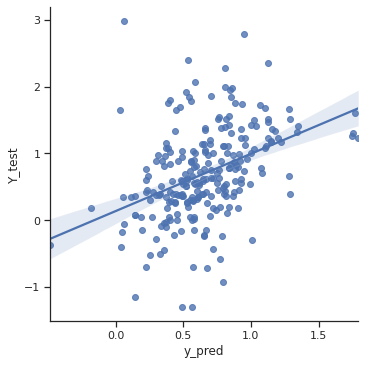

4
(995, 513)
(248, 513)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=46)
Calculating Permutation Importances
248
2-fold :  46.774193548387096
3-fold :  71.37096774193549
5-fold :  85.88709677419355
gmfe :  2.440630165207722
mfe :  1.3771393311795115
bias :  0.4093272870879196
rmse  0.5126184664534309
r2  0.28596328629649803


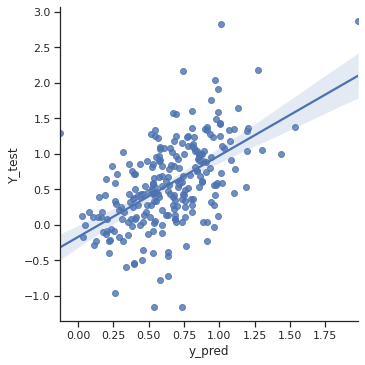

human_thalf
0
(1012, 513)
(253, 513)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=42)
Calculating Permutation Importances
253
2-fold :  46.6403162055336
3-fold :  68.37944664031622
5-fold :  86.56126482213439
gmfe :  2.532783372481821
mfe :  1.3956161877954751
bias :  -0.15676131021167028
rmse  0.5224265985002752
r2  0.30718702603772097
saving model


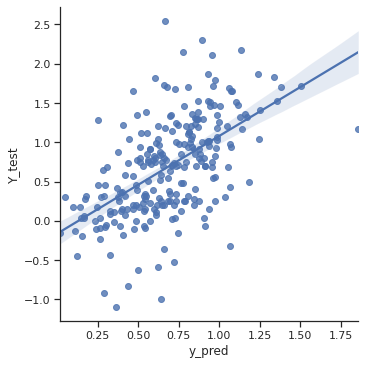

1
(1012, 513)
(253, 513)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_jobs=30, random_state=42)
Calculating Permutation Importances
253
2-fold :  52.569169960474305
3-fold :  69.96047430830039
5-fold :  84.98023715415019
gmfe :  2.4399452416444594
mfe :  1.333873725176743
bias :  0.31011126303052805
rmse  0.5234161261429714
r2  0.2911307726350918
saving model


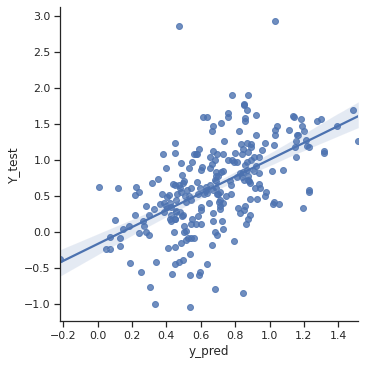

2
(1012, 513)
(253, 513)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_jobs=30, random_state=42)
Calculating Permutation Importances
253
2-fold :  54.54545454545454
3-fold :  73.91304347826086
5-fold :  87.74703557312253
gmfe :  2.309850452454727
mfe :  1.3206252718297593
bias :  0.2065220525405751
rmse  0.4846463940838396
r2  0.30988278668874136
saving model


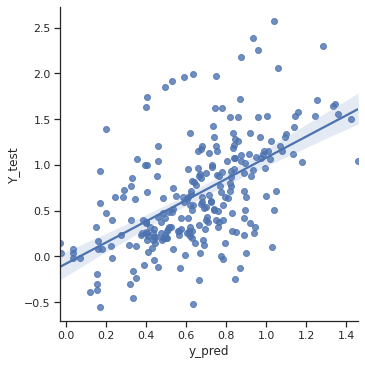

3
(1012, 513)
(253, 513)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=42)
Calculating Permutation Importances
253
2-fold :  50.59288537549407
3-fold :  67.98418972332016
5-fold :  81.81818181818183
gmfe :  2.6891045387558736
mfe :  1.3495063791941488
bias :  0.3417630125693334
rmse  0.5942585842891125
r2  0.277913311867352


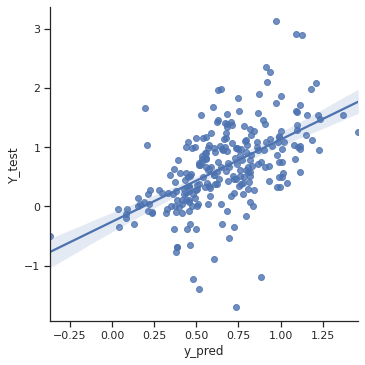

4
(1012, 513)
(253, 513)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=42)
Calculating Permutation Importances
253
2-fold :  54.54545454545454
3-fold :  76.6798418972332
5-fold :  90.51383399209486
gmfe :  2.1699669079939543
mfe :  1.324857899991537
bias :  0.27406049262789756
rmse  0.45160160990368925
r2  0.377730453142878
saving model


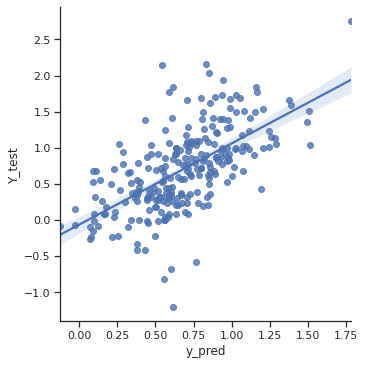

0
(1012, 513)
(253, 513)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=43)
Calculating Permutation Importances
253
2-fold :  48.616600790513836
3-fold :  73.51778656126481
5-fold :  89.72332015810277
gmfe :  2.2577007985895174
mfe :  1.3562698576149865
bias :  -0.01991758166484625
rmse  0.4553534890346654
r2  0.3482000198798564


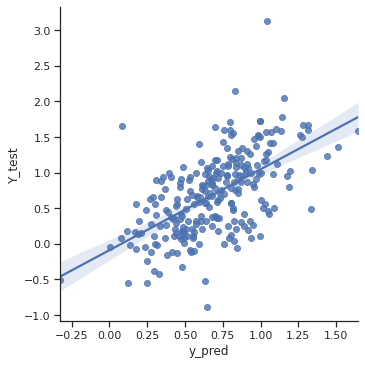

1
(1012, 513)
(253, 513)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=43)
Calculating Permutation Importances
253
2-fold :  50.988142292490124
3-fold :  70.7509881422925
5-fold :  81.02766798418972
gmfe :  2.598703705058226
mfe :  1.3382607273708955
bias :  0.5643206112443346
rmse  0.5748668228822846
r2  0.2570796734457311


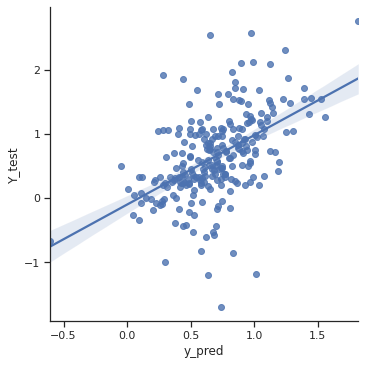

2
(1012, 513)
(253, 513)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=43)
Calculating Permutation Importances
253
2-fold :  50.19762845849802
3-fold :  70.7509881422925
5-fold :  86.95652173913044
gmfe :  2.460337235332426
mfe :  1.34448215138714
bias :  0.16019043047038206
rmse  0.5189358506029295
r2  0.2705142942937476


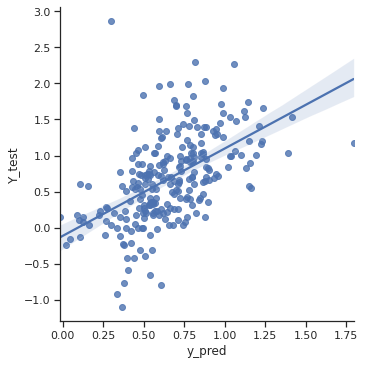

3
(1012, 513)
(253, 513)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=43)
Calculating Permutation Importances
253
2-fold :  50.59288537549407
3-fold :  69.96047430830039
5-fold :  84.18972332015811
gmfe :  2.4563746464212253
mfe :  1.3446234888949258
bias :  0.08509961030856417
rmse  0.5151133998975246
r2  0.3076562734478918


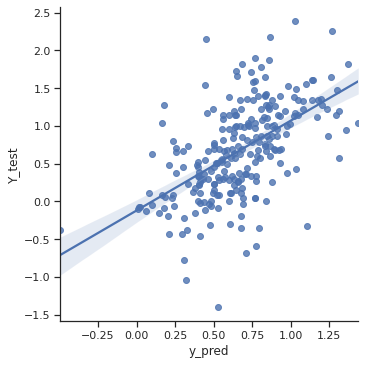

4
(1012, 513)
(253, 513)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=43)
Calculating Permutation Importances
253
2-fold :  51.38339920948617
3-fold :  73.51778656126481
5-fold :  85.37549407114624
gmfe :  2.38666907943579
mfe :  1.3334543424505347
bias :  0.29318558196210365
rmse  0.5218033535433485
r2  0.3570610730597493


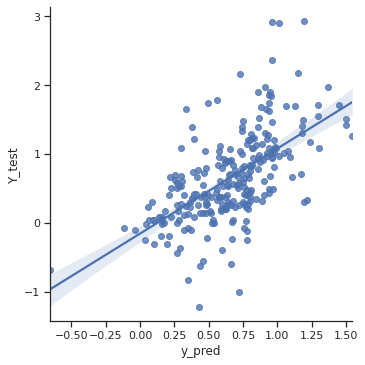

0
(1012, 513)
(253, 513)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_jobs=30, random_state=44)
Calculating Permutation Importances
253
2-fold :  54.54545454545454
3-fold :  79.05138339920948
5-fold :  87.74703557312253
gmfe :  2.226337062032347
mfe :  1.3175558125796099
bias :  0.2756942821470516
rmse  0.46120488664464415
r2  0.34269179872353617


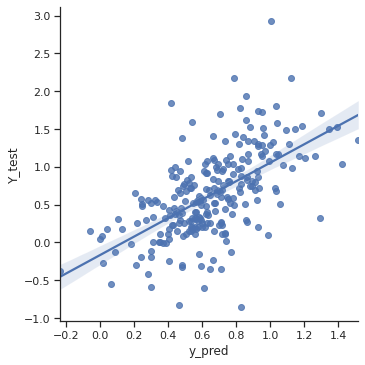

1
(1012, 513)
(253, 513)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_jobs=30, random_state=44)
Calculating Permutation Importances
253
2-fold :  49.01185770750988
3-fold :  70.35573122529645
5-fold :  86.16600790513834
gmfe :  2.5339336943611626
mfe :  1.3591659378921457
bias :  0.11435560928569988
rmse  0.5401576532686633
r2  0.3062848256345888


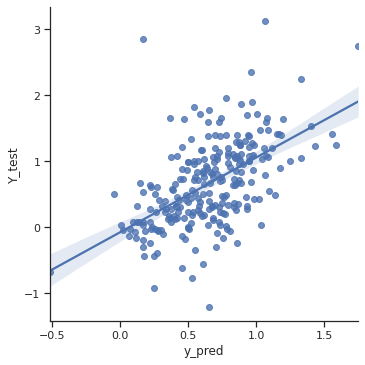

2
(1012, 513)
(253, 513)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=44)
Calculating Permutation Importances
253
2-fold :  52.96442687747036
3-fold :  71.54150197628458
5-fold :  89.32806324110672
gmfe :  2.3447604224700083
mfe :  1.3129749578978567
bias :  0.3032346929910785
rmse  0.4898860863081193
r2  0.33260898298938046


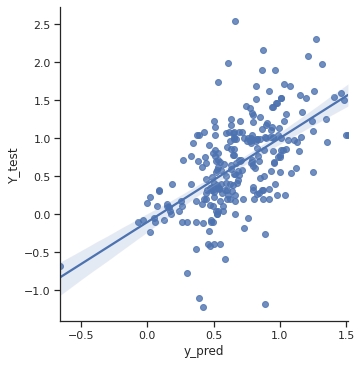

3
(1012, 513)
(253, 513)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=44)
Calculating Permutation Importances
253
2-fold :  47.82608695652174
3-fold :  67.58893280632411
5-fold :  83.79446640316206
gmfe :  2.6133500355869224
mfe :  1.3682189279452903
bias :  0.6162663570407373
rmse  0.5599033464207825
r2  0.28040032908356427


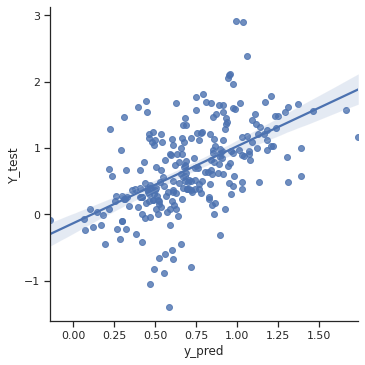

4
(1012, 513)
(253, 513)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_jobs=30, random_state=44)
Calculating Permutation Importances
253
2-fold :  50.988142292490124
3-fold :  70.7509881422925
5-fold :  84.98023715415019
gmfe :  2.510003003968962
mfe :  1.3438485880188993
bias :  0.053787206035204704
rmse  0.5498096261053802
r2  0.24018221943853735


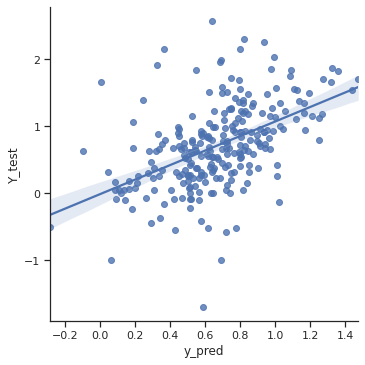

0
(1012, 513)
(253, 513)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=45)
Calculating Permutation Importances
253
2-fold :  45.8498023715415
3-fold :  70.7509881422925
5-fold :  86.16600790513834
gmfe :  2.5133157177234144
mfe :  1.3711622536409054
bias :  0.3957478906852776
rmse  0.5350432034244756
r2  0.26734243746257347


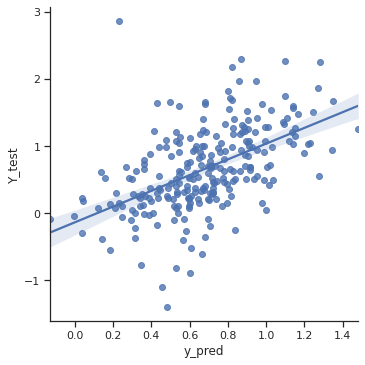

1
(1012, 513)
(253, 513)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_jobs=30, random_state=45)
Calculating Permutation Importances
253
2-fold :  51.38339920948617
3-fold :  71.14624505928853
5-fold :  89.72332015810277
gmfe :  2.2816078155254567
mfe :  1.3453897389642955
bias :  0.20814852359145153
rmse  0.4668492280331127
r2  0.3311359320817935


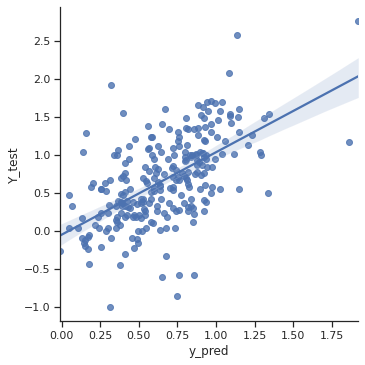

2
(1012, 513)
(253, 513)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_jobs=30, random_state=45)
Calculating Permutation Importances
253
2-fold :  52.17391304347826
3-fold :  72.33201581027669
5-fold :  85.37549407114624
gmfe :  2.4784789326391263
mfe :  1.3237166641970044
bias :  -0.14908283601747185
rmse  0.5494958926710222
r2  0.2704747228025457


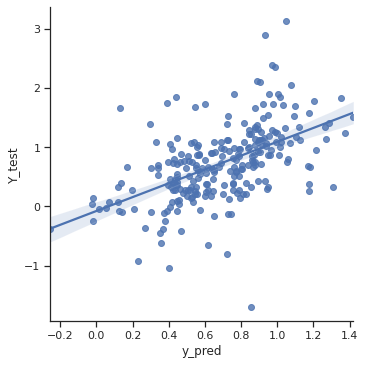

3
(1012, 513)
(253, 513)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=45)
Calculating Permutation Importances
253
2-fold :  51.77865612648221
3-fold :  71.14624505928853
5-fold :  82.6086956521739
gmfe :  2.5260146702750728
mfe :  1.3303713352441224
bias :  0.4377575586464033
rmse  0.5401708207731724
r2  0.3056786183644403


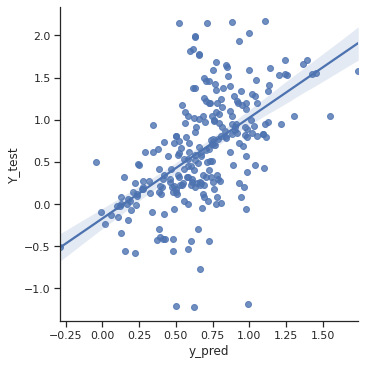

4
(1012, 513)
(253, 513)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=45)
Calculating Permutation Importances
253
2-fold :  52.569169960474305
3-fold :  74.70355731225297
5-fold :  86.95652173913044
gmfe :  2.3606429007778362
mfe :  1.3387539176468042
bias :  0.11993781643256884
rmse  0.5031473940838522
r2  0.3442479274033735


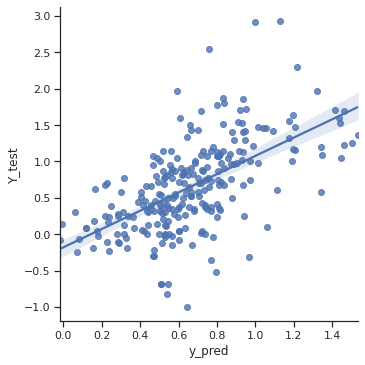

0
(1012, 513)
(253, 513)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=46)
Calculating Permutation Importances
253
2-fold :  46.6403162055336
3-fold :  69.96047430830039
5-fold :  84.18972332015811
gmfe :  2.5843705600387055
mfe :  1.386448528090582
bias :  -0.19447438684958696
rmse  0.5459975642704078
r2  0.21742715809154545


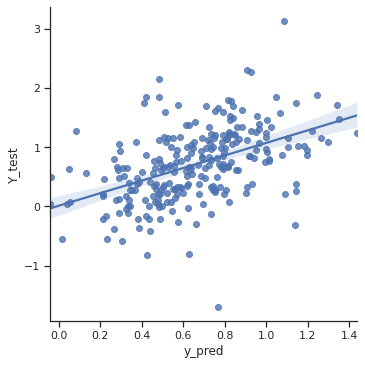

1
(1012, 513)
(253, 513)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=46)
Calculating Permutation Importances
253
2-fold :  52.96442687747036
3-fold :  77.07509881422925
5-fold :  88.93280632411067
gmfe :  2.242276388365715
mfe :  1.338718321521259
bias :  0.11887912428311287
rmse  0.4630530474267414
r2  0.33397582287416194


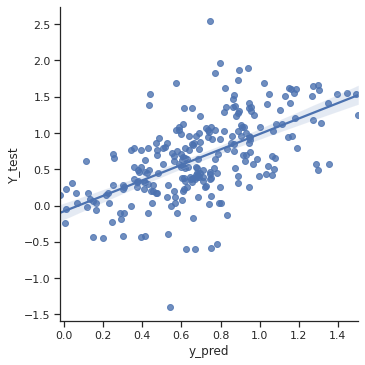

2
(1012, 513)
(253, 513)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=46)
Calculating Permutation Importances
253
2-fold :  51.77865612648221
3-fold :  72.72727272727273
5-fold :  84.18972332015811
gmfe :  2.384410238382117
mfe :  1.3322623432266851
bias :  0.27970204688820965
rmse  0.5071745908605616
r2  0.29936988303678835


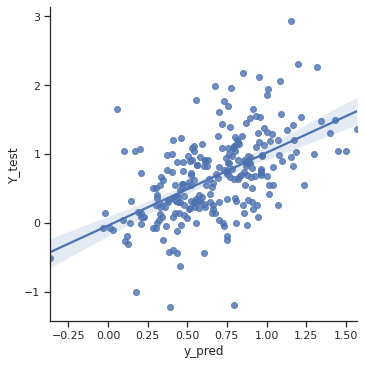

3
(1012, 513)
(253, 513)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_jobs=30, random_state=46)
Calculating Permutation Importances
253
2-fold :  49.01185770750988
3-fold :  68.77470355731225
5-fold :  84.18972332015811
gmfe :  2.6000904821775155
mfe :  1.3784575270498711
bias :  0.48316324277707245
rmse  0.5590301103879083
r2  0.3273622126255433


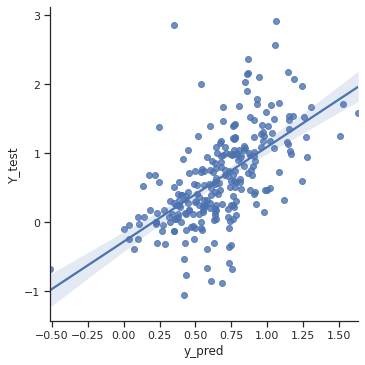

4
(1012, 513)
(253, 513)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=46)
Calculating Permutation Importances
253
2-fold :  50.19762845849802
3-fold :  71.54150197628458
5-fold :  86.56126482213439
gmfe :  2.4274349313683303
mfe :  1.3477727146490641
bias :  0.12806686638375542
rmse  0.5173120872320899
r2  0.3377954010694433


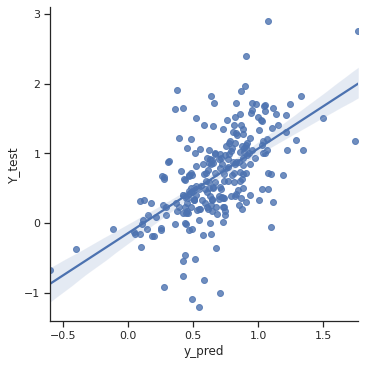

In [23]:
from sklearn.preprocessing import StandardScaler
import pickle
list_of_lists=[]
detail_list_batch=[]
model_parameters_batch=[]


for endpoint in ["human_VDss_L_kg","human_CL_mL_min_kg", "human_fup", "human_mrt", "human_thalf"]:

    data = human_lombardo_mfp_Mordred_animal
    features = features_mfp_mordred_animal_columns
    baseline=10.00

    print(endpoint)    
    df = data.dropna(subset=[endpoint]).reset_index(drop=True)

    X = df[features]
    Y = df[endpoint]
    
    # Scale the features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    X = pd.DataFrame(X, columns=features)
    
    #Nested Cross Validation    
    for i in range(42, 47):
        
        outercv = KFold(n_splits=5, random_state=i, shuffle=True) 

        for split, (train_index, test_index) in enumerate(outercv.split(X)):
            
            print(split)
            train = df.iloc[train_index]
            X_train= X.iloc[train_index].values
            Y_train= Y.iloc[train_index].values.flatten()

            test = df.iloc[test_index]
            X_test= X.iloc[test_index].values
            Y_test= Y.iloc[test_index].values.flatten()

            print(X_train.shape)
            print(X_test.shape)

            inner_cv = KFold(n_splits=4, random_state=i, shuffle=True) 

            # Create a based model
            regressor = RandomForestRegressor(random_state = i, n_jobs=20)

            # Instantiate the RandomHalving search model
            param_grid = { 
            "n_estimators": [100,200,300],
            "max_features": ["sqrt", "log2"],
            "min_samples_split": [2,4,8],
            "max_depth": [5, 10, 15],    
            "bootstrap": [True, False],
            'n_jobs': [30]
            }

            gsh = GridSearchCV(estimator = regressor, param_grid = param_grid, cv = inner_cv, n_jobs=30, verbose = 1)

            ##MODELS
            print(f"Running ____________________{endpoint} MODELS")

            gsh.fit(X_train, Y_train)
            #print(gsh.best_estimator_)

            #HeldOutTest
            classifier = gsh.best_estimator_
            print(classifier)
            
            row=[endpoint, i, split, classifier.n_estimators, classifier.max_features,
                classifier.min_samples_split, classifier.max_depth, classifier.bootstrap]
            model_parameters_batch.append(row)
            
            
            classifier.fit(X_train, Y_train)

            print("Calculating Permutation Importances")  
            y_pred =  classifier.predict(X_test)     
            print(len(y_pred))

            fold_2= count(y_pred, Y_test, 0.5, 2, endpoint)
            fold_3= count(y_pred, Y_test, 1/3, 3, endpoint)
            fold_5= count(y_pred, Y_test, 1/5, 5, endpoint)
            gmfe = calc_gmfe(y_pred, Y_test, endpoint)
            mfe = median_fold_change_error(y_pred, Y_test, endpoint)
            bias = calc_bias(y_pred, Y_test, endpoint)

            print("2-fold : ", fold_2)
            print("3-fold : ", fold_3)
            print("5-fold : ", fold_5)
            print("gmfe : ", gmfe)
            print("mfe : ", mfe)
            print("bias : ", bias)

            rmse = sqrt(mean_squared_error(Y_test, y_pred))
            print('rmse ',rmse)
            r2 = r2_score(Y_test, y_pred)
            print('r2 ',r2)

            if (gmfe<baseline):
                # save
                print("saving model")
                baseline=gmfe
                pickle.dump(classifier, open(f"log_{endpoint}_withanimaldata_artificial_model.sav",  'wb'))

            sns.set_theme(style="ticks")
            df_plot=pd.DataFrame({"y_pred":y_pred, "Y_test":Y_test})
            sns.lmplot(data=df_plot, x="y_pred", y="Y_test")
            plt.show()

            row=["HeldOut",  endpoint, i, split, fold_2, fold_3, fold_5, gmfe, mfe, bias, rmse, r2]
            list_of_lists.append(row)
            
            #combine results
            for smiles_r, pred, true in zip(test.smiles_r, y_pred, Y_test):
                detail_list_batch.append([endpoint, i, split, smiles_r, pred, true])


In [24]:
model_parameters= pd.DataFrame(model_parameters_batch,columns=["endpoint", "random_state", 
                                                            "split", "n_estimators", "max_features",
                "min_samples_split", "max_depth", "bootstrap"])
model_parameters

endpoint  random_state  split  n_estimators max_features  \
0    human_VDss_L_kg            42      0           200         sqrt   
1    human_VDss_L_kg            42      1           200         sqrt   
2    human_VDss_L_kg            42      2           300         sqrt   
3    human_VDss_L_kg            42      3           200         sqrt   
4    human_VDss_L_kg            42      4           100         sqrt   
..               ...           ...    ...           ...          ...   
120      human_thalf            46      0           300         sqrt   
121      human_thalf            46      1           300         sqrt   
122      human_thalf            46      2           200         sqrt   
123      human_thalf            46      3           100         sqrt   
124      human_thalf            46      4           300         sqrt   

     min_samples_split  max_depth  bootstrap  
0                    4         15      False  
1                    2         15      False  
2                    2         15      False  
3                    2         15      False  
4                    8         15      False  
..                 ...        ...        ...  
120                  4         15      False  
121                  4         15      False  
122                  2         15      False  
123                  8         15      False  
124                  4         15      False  

[125 rows x 8 columns]

In [25]:
detail_list = pd.DataFrame(detail_list_batch,columns=["endpoint", "random_state", 
                                                           "split", "smiles_r", "pred", "true"])
detail_list["key"] =  detail_list["endpoint"].astype(str) + detail_list["smiles_r"].astype(str) + detail_list["random_state"].astype(str)+ detail_list["split"].astype(str)
detail_list

endpoint  random_state  split  \
0      human_VDss_L_kg            42      0   
1      human_VDss_L_kg            42      0   
2      human_VDss_L_kg            42      0   
3      human_VDss_L_kg            42      0   
4      human_VDss_L_kg            42      0   
...                ...           ...    ...   
29580      human_thalf            46      4   
29581      human_thalf            46      4   
29582      human_thalf            46      4   
29583      human_thalf            46      4   
29584      human_thalf            46      4   

                                                smiles_r      pred      true  \
0      C#C[C@]1(O)CC[C@H]2[C@@H]3CCc4cc([O-])ccc4[C@H...  0.278796  0.633468   
1      C=C(CC(NC(=O)c1ccc(CCc2cnc3nc(N)nc(N)c3n2)cc1)... -0.048287 -0.154902   
2      C=CC1=C(C(=O)[O-])[NH+]2C(=O)C(=NC(=O)C(NOCC(=... -0.712607 -0.619789   
3                         C=CCc1ccccc1OCC(O)C[NH2+]C(C)C  0.366459  0.505150   
4      C=C[C@@H]1C[C@]1(NC(=O)C1C[C@@H](Oc2ncc(OC)c3c...  0.033923  0.442480   
...                                                  ...       ...       ...   
29580  [NH3+]CCCCC(NC(=O)C(Cc1cc(Br)c([O-])c(Br)c1)NC...  0.934596  0.397940   
29581                 [NH3+]C[C@H]1OB(O)c2c(OCCCO)cccc21  0.549054  1.064458   
29582                [O-]c1ccc(C2=Cc3ccc([O-])cc3OC2)cc1  0.578109 -0.173925   
29583  [O-]c1ccc([C@H]2C[NH2+]CCc3c2cc([O-])c([O-])c3...  0.631691  0.000000   
29584                c1ccc(CN(CC2=[NH+]CCN2)c2ccccc2)cc1  0.864460  0.359835   

                                                     key  
0      human_VDss_L_kgC#C[C@]1(O)CC[C@H]2[C@@H]3CCc4c...  
1      human_VDss_L_kgC=C(CC(NC(=O)c1ccc(CCc2cnc3nc(N...  
2      human_VDss_L_kgC=CC1=C(C(=O)[O-])[NH+]2C(=O)C(...  
3       human_VDss_L_kgC=CCc1ccccc1OCC(O)C[NH2+]C(C)C420  
4      human_VDss_L_kgC=C[C@@H]1C[C@]1(NC(=O)C1C[C@@H...  
...                                                  ...  
29580  human_thalf[NH3+]CCCCC(NC(=O)C(Cc1cc(Br)c([O-]...  
29581   human_thalf[NH3+]C[C@H]1OB(O)c2c(OCCCO)cccc21464  
29582  human_thalf[O-]c1ccc(C2=Cc3ccc([O-])cc3OC2)cc1464  
29583  human_thalf[O-]c1ccc([C@H]2C[NH2+]CCc3c2cc([O-...  
29584  human_thalfc1ccc(CN(CC2=[NH+]CCN2)c2ccccc2)cc1464  

[29585 rows x 7 columns]

In [26]:
results = pd.DataFrame(list_of_lists, columns=["HeldOut", "endpoint", "random_state", "split", "fold_2", "fold_3", "fold_5", "gmfe", "mfe", "bias", "rmse", "r2"])
results

HeldOut         endpoint  random_state  split     fold_2     fold_3  \
0    HeldOut  human_VDss_L_kg            42      0  56.400000  74.400000   
1    HeldOut  human_VDss_L_kg            42      1  59.200000  77.600000   
2    HeldOut  human_VDss_L_kg            42      2  57.600000  74.800000   
3    HeldOut  human_VDss_L_kg            42      3  59.600000  74.800000   
4    HeldOut  human_VDss_L_kg            42      4  53.413655  75.100402   
..       ...              ...           ...    ...        ...        ...   
120  HeldOut      human_thalf            46      0  46.640316  69.960474   
121  HeldOut      human_thalf            46      1  52.964427  77.075099   
122  HeldOut      human_thalf            46      2  51.778656  72.727273   
123  HeldOut      human_thalf            46      3  49.011858  68.774704   
124  HeldOut      human_thalf            46      4  50.197628  71.541502   

        fold_5      gmfe       mfe      bias      rmse        r2  
0    88.000000  2.143691  1.295999  0.020964  0.441773  0.547675  
1    89.200000  2.064582  1.280330  0.103263  0.408703  0.552588  
2    85.200000  2.196932  1.261919 -0.000585  0.473505  0.483840  
3    90.400000  2.099182  1.292881  0.013990  0.423201  0.572354  
4    90.763052  2.175660  1.320055  0.059467  0.439406  0.499571  
..         ...       ...       ...       ...       ...       ...  
120  84.189723  2.584371  1.386449 -0.194474  0.545998  0.217427  
121  88.932806  2.242276  1.338718  0.118879  0.463053  0.333976  
122  84.189723  2.384410  1.332262  0.279702  0.507175  0.299370  
123  84.189723  2.600090  1.378458  0.483163  0.559030  0.327362  
124  86.561265  2.427435  1.347773  0.128067  0.517312  0.337795  

[125 rows x 12 columns]

In [27]:
model_parameters.to_csv("model_parameters_Prediction_human_from_mordred_morgan_fs_animal_artificial.csv", index=False)

In [28]:
detail_list.to_csv("detail_list_Prediction_human_from_mordred_morgan_fs_animal_artificial.csv", index=False)

In [29]:
results.to_csv("Prediction_human_from_mordred_morgan_fs_animal_artificial.csv", index=False)

In [30]:
import pandas as pd
results= pd.read_csv("Prediction_human_from_mordred_morgan_fs_animal_artificial.csv")
results.groupby("endpoint").mean().reset_index().to_csv("human_with_mfp_mordred_animal_artificial.csv", index=False)
results.groupby("endpoint").mean()

random_state  split     fold_2     fold_3     fold_5  \
endpoint                                                                   
human_CL_mL_min_kg          44.0    2.0  50.694796  70.101107  84.652055   
human_VDss_L_kg             44.0    2.0  57.614072  75.517237  89.368867   
human_fup                   44.0    2.0  55.540519  67.348831  78.361558   
human_mrt                   44.0    2.0  50.007967  70.570475  83.490802   
human_thalf                 44.0    2.0  50.814229  71.794466  85.992095   

                        gmfe       mfe      bias      rmse        r2  
endpoint                                                              
human_CL_mL_min_kg  2.481616  1.346101 -0.279106  0.540297  0.302139  
human_VDss_L_kg     2.130642  1.286394  0.032320  0.437090  0.531292  
human_fup           2.751347  1.280307  0.037105  0.209970  0.616249  
human_mrt           2.509230  1.353817  0.073923  0.543498  0.277152  
human_thalf         2.437139  1.345456  0.209990  0.518026  0.305653

In [31]:
# load
loaded_rf = pickle.load(open("log_human_VDss_L_kg_withanimaldata_artificial_model.sav", 'rb'))

In [34]:
import pickle
list_of_lists=[]


for endpoint in ["human_VDss_L_kg","human_CL_mL_min_kg", "human_fup", "human_mrt", "human_thalf"]:

    data = human_lombardo_mfp_Mordred_animal
    features = features_mfp_mordred_animal_columns

    print(endpoint)    
    df = data.dropna(subset=[endpoint]).reset_index(drop=True)

    X = df[features]
    Y = df[endpoint]

    # Scale the features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    X = pd.DataFrame(X, columns=features)
    
    # Save the scaler to a file
    with open(f'artificial_animal_data_mfp_mrd_{endpoint}_scaler.pkl', 'wb') as file:
        pickle.dump(scaler, file)
    
    X_train= X.values
    Y_train= Y.values.flatten()

    print(X_train.shape)
          
    loaded_rf = pickle.load(open(f"log_{endpoint}_withanimaldata_artificial_model.sav", 'rb'))
    params = loaded_rf.get_params()
    
    classifier= RandomForestRegressor(**params)
    classifier.fit(X_train, Y_train)
    
    pickle.dump(classifier, open(f"log_{endpoint}_withanimaldata_artificial_model_FINAL.sav", 'wb'))

human_VDss_L_kg
(1249, 513)
human_CL_mL_min_kg
(1281, 513)
human_fup
(879, 513)
human_mrt
(1243, 513)
human_thalf
(1265, 513)


In [35]:
for endpoint in ["human_VDss_L_kg","human_CL_mL_min_kg", "human_fup", "human_mrt", "human_thalf"]:
    loaded_rf = pickle.load(open(f"log_{endpoint}_withanimaldata_artificial_model.sav", 'rb'))
    params = loaded_rf.get_params()
    print(endpoint)
    print(params)
    

human_VDss_L_kg
{'bootstrap': False, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 15, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 300, 'n_jobs': 30, 'oob_score': False, 'random_state': 44, 'verbose': 0, 'warm_start': False}
human_CL_mL_min_kg
{'bootstrap': False, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 15, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 300, 'n_jobs': 30, 'oob_score': False, 'random_state': 46, 'verbose': 0, 'warm_start': False}
human_fup
{'bootstrap': False, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 15, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 

In [36]:
import pandas as pd
detail= pd.read_csv("detail_list_Prediction_human_from_mordred_morgan_fs_animal_artificial.csv")
detail[detail["smiles_r"]=="N#CN"]

Empty DataFrame
Columns: [endpoint, random_state, split, smiles_r, pred, true, key]
Index: []